In [1]:
# !rm -rf DENTEX_000_test_image.png
# !rm -rf DENTEX_015_test_image.png

Ячейка 1

In [2]:
# 1. Установка необходимых библиотек
!pip install -q tensorflow opencv-python matplotlib scikit-learn scikit-image huggingface_hub

# Импорт необходимых библиотек
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
import cv2
from pathlib import Path
import random
import time
import shutil
from google.colab import drive
import glob
import subprocess

Ячейка 2

In [3]:
# 2. Настройка окружения и конфигурация
# Настройка памяти GPU, если доступна
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Использование {len(gpus)} GPU")
    except RuntimeError as e:
        print(e)
else:
    print("GPU не обнаружен, используется CPU")

# Монтирование Google Drive (если потребуется сохранить результаты)
drive.mount('/content/drive')

# Создание директории для результатов
RESULTS_DIR = '/content/results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Конфигурация системы
CONFIG = {
    "img_size": 512,           # Размер входного изображения
    "batch_size": 8,           # Размер батча
    "epochs": 100,             # Количество эпох
    "early_stopping": 10,      # Ранняя остановка (количество эпох)
    "learning_rate": 1e-4,     # Скорость обучения
    "validation_split": 0.2,   # Доля данных для валидации
    "num_classes": 5,          # Количество классов (фон + 4 патологии)
    "target_metrics": {        # Веса метрик для целевой функции
        "sensitivity_weight": 1.0,    # c1
        "specificity_weight": 0.8,    # c2
        "accuracy_weight": 1.0,       # c3
        "dice_weight": 1.2,           # c4 (F-мера)
        "bce_weight": 2.0,            # c5 (бинарная кросс-энтропия)
        "calibration_weight": 1.5     # c6 (калибровка вероятностей)
    },
    "class_weights": {         # Веса для разных классов патологий
        0: 0.1,                # фон (нормальная ткань)
        1: 2.0,                # кариес
        2: 3.5,                # глубокий кариес
        3: 4.0,                # периапикальные поражения
        4: 2.5                 # ретинированные зубы
    }
}

Использование 1 GPU
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ячейка 3

In [4]:
# 3. Функция для загрузки датасета DENTEX
def download_dentex_dataset():
    """
    Скачивание и распаковка датасета DENTEX.
    """
    from huggingface_hub import snapshot_download
    # Путь для сохранения датасета
    dataset_path = '/content/DENTEX'
    # Проверяем, существует ли датасет
    if os.path.exists(dataset_path) and len(os.listdir(dataset_path)) > 0:
        print(f"Датасет уже скачан в {dataset_path}")
        return dataset_path
    print("Загрузка датасета DENTEX...")
    # Скачивание датасета с Hugging Face
    try:
        snapshot_download(
            repo_id="ibrahimhamamci/DENTEX",
            repo_type="dataset",
            local_dir=dataset_path,
            local_dir_use_symlinks=False
        )
        print(f"Датасет загружен в: {dataset_path}")
    except Exception as e:
        print(f"Ошибка при загрузке: {str(e)}")
        return None
    # Извлечение данных (если они в архиве)
    extracted_path = '/content/DENTEX_extracted'
    os.makedirs(extracted_path, exist_ok=True)
    # Проверка на наличие архивов
    archives = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.zip'):
                archives.append(os.path.join(root, file))
    # Распаковка архивов
    if archives:
        print("Распаковка архивов...")
        import zipfile
        for archive in archives:
            with zipfile.ZipFile(archive, 'r') as zip_ref:
                zip_ref.extractall(extracted_path)
        print(f"Данные распакованы в {extracted_path}")
        return extracted_path
    return dataset_path

# Загрузка датасета
dataset_path = download_dentex_dataset()
print(f"Путь к датасету: {dataset_path}")

# Функция для диагностики структуры датасета
def diagnose_dentex_dataset():
    """Функция для диагностики структуры датасета DENTEX"""
    print("\n=== ДИАГНОСТИКА ДАТАСЕТА DENTEX ===\n")

    # Проверяем основные директории
    base_dirs = ["/content/DENTEX", "/content/DENTEX_extracted"]
    for base_dir in base_dirs:
        if os.path.exists(base_dir):
            print(f"\n📁 Директория {base_dir} существует")

            # Показываем содержимое первого уровня
            contents = os.listdir(base_dir)
            print(f"  Содержимое ({len(contents)} элементов):")
            for item in contents[:10]:  # Показать первые 10
                item_path = os.path.join(base_dir, item)
                if os.path.isdir(item_path):
                    print(f"    📁 {item} (папка)")
                else:
                    print(f"    📄 {item} (файл)")

            if len(contents) > 10:
                print(f"    ... и еще {len(contents) - 10} элементов")

            # Проверяем наличие training_data
            training_path = os.path.join(base_dir, "training_data")
            if os.path.exists(training_path):
                print(f"\n  📁 Директория training_data найдена")

                # Проверяем поддиректории
                training_contents = os.listdir(training_path)
                print(f"    Содержимое ({len(training_contents)} элементов):")
                for item in training_contents:
                    print(f"      - {item}")

                # Проверяем наличие директории quadrant-enumeration-disease
                qed_path = os.path.join(training_path, "quadrant-enumeration-disease")
                if os.path.exists(qed_path):
                    print(f"\n    📁 Директория quadrant-enumeration-disease найдена")
                    qed_contents = os.listdir(qed_path)
                    print(f"      Содержимое ({len(qed_contents)} элементов):")
                    for item in qed_contents:
                        print(f"        - {item}")

                    # Проверяем директорию xrays
                    xrays_path = os.path.join(qed_path, "xrays")
                    if os.path.exists(xrays_path):
                        print(f"\n      📁 Директория xrays найдена!")
                        xrays_contents = os.listdir(xrays_path)
                        print(f"        Содержит {len(xrays_contents)} файлов")
                        print(f"        Примеры файлов: {', '.join(xrays_contents[:3])}")
                    else:
                        print(f"\n      ❌ Директория xrays НЕ найдена!")
                else:
                    print(f"\n    ❌ Директория quadrant-enumeration-disease НЕ найдена!")
            else:
                print(f"\n  ❌ Директория training_data НЕ найдена!")
        else:
            print(f"\n❌ Директория {base_dir} НЕ существует")

    # Ищем файлы аннотаций
    print("\n=== ПОИСК ФАЙЛОВ АННОТАЦИЙ ===\n")
    for base_dir in base_dirs:
        if not os.path.exists(base_dir):
            continue

        for root, dirs, files in os.walk(base_dir):
            json_files = [f for f in files if f.endswith('.json')]
            if json_files:
                print(f"Найдены JSON-файлы в {root}:")
                for json_file in json_files:
                    print(f"  - {json_file}")

    # Ищем PNG-файлы
    print("\n=== ПОИСК PNG-ФАЙЛОВ ===\n")
    png_locations = {}
    for base_dir in base_dirs:
        if not os.path.exists(base_dir):
            continue

        for root, dirs, files in os.walk(base_dir):
            png_files = [f for f in files if f.endswith('.png')]
            if png_files:
                png_locations[root] = len(png_files)

    # Сортируем по количеству файлов
    sorted_locations = sorted(png_locations.items(), key=lambda x: x[1], reverse=True)
    print(f"Найдено {len(sorted_locations)} директорий с PNG-файлами:")
    for location, count in sorted_locations:
        print(f"  - {location}: {count} файлов")
        if count > 0:
            # Показать примеры файлов
            examples = [f for f in os.listdir(location) if f.endswith('.png')][:3]
            print(f"    Примеры: {', '.join(examples)}")

    print("\n=== ДИАГНОСТИКА ЗАВЕРШЕНА ===\n")

# Запуск диагностики
diagnose_dentex_dataset()

Датасет уже скачан в /content/DENTEX
Путь к датасету: /content/DENTEX

=== ДИАГНОСТИКА ДАТАСЕТА DENTEX ===


📁 Директория /content/DENTEX существует
  Содержимое (5 элементов):
    📁 DENTEX (папка)
    📁 .cache (папка)
    📄 README.md (файл)
    📁 figures (папка)
    📄 .gitattributes (файл)

  ❌ Директория training_data НЕ найдена!

📁 Директория /content/DENTEX_extracted существует
  Содержимое (3 элементов):
    📁 disease (папка)
    📁 training_data (папка)
    📁 validation_data (папка)

  📁 Директория training_data найдена
    Содержимое (4 элементов):
      - quadrant-enumeration-disease
      - unlabelled
      - quadrant_enumeration
      - quadrant

    📁 Директория quadrant-enumeration-disease найдена
      Содержимое (2 элементов):
        - xrays
        - train_quadrant_enumeration_disease.json

      📁 Директория xrays найдена!
        Содержит 705 файлов
        Примеры файлов: train_688.png, train_673.png, train_386.png

=== ПОИСК ФАЙЛОВ АННОТАЦИЙ ===

Найдены JSON-файлы в

In [5]:
# def diagnose_dentex_dataset():
#     """Функция для диагностики структуры датасета DENTEX"""
#     print("\n=== ДИАГНОСТИКА ДАТАСЕТА DENTEX ===\n")

#     # Проверяем основные директории
#     base_dirs = ["/content/DENTEX", "/content/DENTEX_extracted"]
#     for base_dir in base_dirs:
#         if os.path.exists(base_dir):
#             print(f"\n📁 Директория {base_dir} существует")

#             # Показываем содержимое первого уровня
#             contents = os.listdir(base_dir)
#             print(f"  Содержимое ({len(contents)} элементов):")
#             for item in contents[:10]:  # Показать первые 10
#                 item_path = os.path.join(base_dir, item)
#                 if os.path.isdir(item_path):
#                     print(f"    📁 {item} (папка)")
#                 else:
#                     print(f"    📄 {item} (файл)")

#             if len(contents) > 10:
#                 print(f"    ... и еще {len(contents) - 10} элементов")

#             # Проверяем наличие training_data
#             training_path = os.path.join(base_dir, "training_data")
#             if os.path.exists(training_path):
#                 print(f"\n  📁 Директория training_data найдена")

#                 # Проверяем поддиректории
#                 training_contents = os.listdir(training_path)
#                 print(f"    Содержимое ({len(training_contents)} элементов):")
#                 for item in training_contents:
#                     print(f"      - {item}")

#                 # Проверяем наличие директории quadrant-enumeration-disease
#                 qed_path = os.path.join(training_path, "quadrant-enumeration-disease")
#                 if os.path.exists(qed_path):
#                     print(f"\n    📁 Директория quadrant-enumeration-disease найдена")
#                     qed_contents = os.listdir(qed_path)
#                     print(f"      Содержимое ({len(qed_contents)} элементов):")
#                     for item in qed_contents:
#                         print(f"        - {item}")

#                     # Проверяем директорию xrays
#                     xrays_path = os.path.join(qed_path, "xrays")
#                     if os.path.exists(xrays_path):
#                         print(f"\n      📁 Директория xrays найдена!")
#                         xrays_contents = os.listdir(xrays_path)
#                         print(f"        Содержит {len(xrays_contents)} файлов")
#                         print(f"        Примеры файлов: {', '.join(xrays_contents[:3])}")
#                     else:
#                         print(f"\n      ❌ Директория xrays НЕ найдена!")
#                 else:
#                     print(f"\n    ❌ Директория quadrant-enumeration-disease НЕ найдена!")
#             else:
#                 print(f"\n  ❌ Директория training_data НЕ найдена!")
#         else:
#             print(f"\n❌ Директория {base_dir} НЕ существует")

#     # Ищем файлы аннотаций
#     print("\n=== ПОИСК ФАЙЛОВ АННОТАЦИЙ ===\n")
#     for base_dir in base_dirs:
#         if not os.path.exists(base_dir):
#             continue

#         for root, dirs, files in os.walk(base_dir):
#             json_files = [f for f in files if f.endswith('.json')]
#             if json_files:
#                 print(f"Найдены JSON-файлы в {root}:")
#                 for json_file in json_files:
#                     print(f"  - {json_file}")

#     # Ищем PNG-файлы
#     print("\n=== ПОИСК PNG-ФАЙЛОВ ===\n")
#     png_locations = {}
#     for base_dir in base_dirs:
#         if not os.path.exists(base_dir):
#             continue

#         for root, dirs, files in os.walk(base_dir):
#             png_files = [f for f in files if f.endswith('.png')]
#             if png_files:
#                 png_locations[root] = len(png_files)

#     # Сортируем по количеству файлов
#     sorted_locations = sorted(png_locations.items(), key=lambda x: x[1], reverse=True)
#     print(f"Найдено {len(sorted_locations)} директорий с PNG-файлами:")
#     for location, count in sorted_locations:
#         print(f"  - {location}: {count} файлов")
#         if count > 0:
#             # Показать примеры файлов
#             examples = [f for f in os.listdir(location) if f.endswith('.png')][:3]
#             print(f"    Примеры: {', '.join(examples)}")

#     print("\n=== ДИАГНОСТИКА ЗАВЕРШЕНА ===\n")

# # Запуск диагностики
# diagnose_dentex_dataset()

Проверка

In [6]:
# Проверка конкретного файла
def check_specific_file(file_path):
    """Проверка конкретного файла с подробной диагностикой"""
    print(f"\n=== ПРОВЕРКА ФАЙЛА {file_path} ===\n")

    # Проверка существования
    exists = os.path.exists(file_path)
    print(f"os.path.exists: {exists}")

    # Проверка через Path
    from pathlib import Path
    path_exists = Path(file_path).exists()
    print(f"Path.exists: {path_exists}")

    # Проверка родительской директории
    parent_dir = os.path.dirname(file_path)
    parent_exists = os.path.exists(parent_dir)
    print(f"Родительская директория {parent_dir} существует: {parent_exists}")

    if parent_exists:
        # Список файлов в родительской директории
        try:
            files = os.listdir(parent_dir)
            print(f"Файлы в родительской директории ({len(files)}):")

            # Ищем файл с похожим именем
            base_name = os.path.basename(file_path)
            similar_files = [f for f in files if f.lower() == base_name.lower()]

            if similar_files:
                print(f"Найдены похожие файлы: {similar_files}")
            else:
                # Показать несколько примеров файлов
                print(f"Примеры файлов: {', '.join(files[:5])}")

                # Проверка на частичное совпадение
                partial_matches = [f for f in files if base_name[:5] in f]
                if partial_matches:
                    print(f"Частичные совпадения: {partial_matches}")
        except Exception as e:
            print(f"Ошибка при получении списка файлов: {e}")

    # Прямой доступ к файлу
    if exists:
        try:
            # Пробуем открыть файл
            with open(file_path, 'rb') as f:
                first_bytes = f.read(10)
                print(f"Успешно открыт файл, первые байты: {first_bytes}")
        except Exception as e:
            print(f"Ошибка при открытии файла: {e}")

    print("\n=== ПРОВЕРКА ЗАВЕРШЕНА ===\n")

# Проверим конкретный файл
check_specific_file('/content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays/train_435.png')


=== ПРОВЕРКА ФАЙЛА /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays/train_435.png ===

os.path.exists: True
Path.exists: True
Родительская директория /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays существует: True
Файлы в родительской директории (705):
Найдены похожие файлы: ['train_435.png']
Успешно открыт файл, первые байты: b'\x89PNG\r\n\x1a\n\x00\x00'

=== ПРОВЕРКА ЗАВЕРШЕНА ===



Ячейка 4

In [7]:
# 4. Класс DENTEXDataset - с поддержкой мультиклассовой сегментации
class DENTEXDataset:
    """
    Класс для работы с датасетом DENTEX с поддержкой мультиклассовой сегментации
    """
    def __init__(self, base_dir, img_size=CONFIG["img_size"], batch_size=CONFIG["batch_size"]):
        """
        Инициализация класса для работы с данными DENTEX.

        Аргументы:
            base_dir (str): Корневая директория с данными DENTEX
            img_size (int): Размер изображения (одно значение, т.к. предполагаем квадратное изображение)
            batch_size (int): Размер батча для обучения
        """
        self.base_dir = Path(base_dir) if base_dir else None
        self.img_size = img_size
        self.batch_size = batch_size

        # Классы патологий
        self.disease_classes = {
            0: "Background",
            1: "Caries",
            2: "Deep Caries",
            3: "Periapical",
            4: "Impacted"
        }

        # Количество классов: фон (0) + 4 типа патологий
        self.num_classes = len(self.disease_classes)

        # Цветовая карта для визуализации
        self.class_colors = {
            0: [0, 0, 0],       # Черный - фон
            1: [255, 0, 0],     # Красный - кариес
            2: [0, 255, 0],     # Зеленый - глубокий кариес
            3: [0, 0, 255],     # Синий - периапикальные поражения
            4: [255, 255, 0]    # Желтый - ретинированные зубы
        }

        # Проверяем явно директорию DENTEX_extracted
        dentex_extracted = Path("/content/DENTEX_extracted")
        if dentex_extracted.exists() and (self.base_dir is None or not self.base_dir.exists()):
            print(f"Директория {self.base_dir} не найдена, используем {dentex_extracted}")
            self.base_dir = dentex_extracted

        # Пути к данным
        self.disease_xrays_dir = self._find_disease_xrays_dir()
        self.disease_annotations_file = self._find_disease_annotations_file()

        if not self.disease_xrays_dir or not self.disease_annotations_file:
            print("ВНИМАНИЕ: Не удалось найти пути к данным. Пути устанавливаются вручную.")

            # Используем известный путь к DENTEX_extracted, если он есть
            if dentex_extracted.exists():
                # Попробуем найти xrays рекурсивно
                xray_dirs = list(dentex_extracted.glob("**/xrays"))
                if xray_dirs:
                    self.disease_xrays_dir = xray_dirs[0]
                    print(f"Найдена директория с изображениями: {self.disease_xrays_dir}")
                else:
                    self.disease_xrays_dir = dentex_extracted
                    print(f"Используем корневую директорию: {self.disease_xrays_dir}")

                # Ищем JSON файлы
                json_files = list(dentex_extracted.glob("**/*.json"))
                if json_files:
                    self.disease_annotations_file = json_files[0]
                    print(f"Найден файл аннотаций: {self.disease_annotations_file}")
            else:
                # Стандартные пути по умолчанию
                self.disease_xrays_dir = Path("/content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays")
                self.disease_annotations_file = Path("/content/DENTEX_extracted/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json")

        print(f"Путь к изображениям: {self.disease_xrays_dir}")
        print(f"Путь к аннотациям: {self.disease_annotations_file}")

        # Загрузка классов из файла аннотаций
        self._load_class_definitions()

        # Загрузка изображений и аннотаций
        self.images = []
        self.annotations = []

        if self.disease_xrays_dir and self.disease_xrays_dir.exists():
            # Если нет файла аннотаций, просто загружаем изображения
            if not self.disease_annotations_file or not self.disease_annotations_file.exists():
                print("Файл аннотаций не найден. Загружаем только изображения без аннотаций.")
                self.images = [str(f) for f in self.disease_xrays_dir.glob("**/*.png")]
                self.annotations = [[] for _ in self.images]  # Пустые аннотации
                print(f"Загружено {len(self.images)} изображений без аннотаций")
            else:
                # Если есть и директория с изображениями, и файл аннотаций - загружаем всё
                self.images, self.annotations = self._load_annotations()
                print(f"Загружено {len(self.images)} изображений с аннотациями")
        else:
            print("ПРЕДУПРЕЖДЕНИЕ: Директория с изображениями не найдена!")

    def _find_disease_xrays_dir(self):
        """Поиск директории с рентгеновскими снимками с приоритетом training_data"""
        # Проверяем, есть ли "/content/DENTEX_extracted" директория
        dentex_extracted = Path("/content/DENTEX_extracted")

        # Приоритетные пути - сначала проверяем training_data
        priority_paths = [
            dentex_extracted / "training_data" / "quadrant-enumeration-disease" / "xrays",
            dentex_extracted / "training_data" / "quadrant_enumeration_disease" / "xrays",
            self.base_dir / "training_data" / "quadrant-enumeration-disease" / "xrays" if self.base_dir else None,
            self.base_dir / "training_data" / "quadrant_enumeration_disease" / "xrays" if self.base_dir else None
        ]

        # Отфильтруем None значения
        priority_paths = [path for path in priority_paths if path is not None]

        # Проверим приоритетные пути ПЕРВЫМИ
        for path in priority_paths:
            if path.exists() and path.is_dir():
                if any(path.glob("*.png")):
                    print(f"Найдена директория с изображениями по приоритетному пути: {path}")
                    return path

        # Дополнительные возможные пути
        possible_paths = [
            dentex_extracted / "validation_data" / "quadrant-enumeration-disease" / "xrays",
            dentex_extracted / "validation_data" / "quadrant_enumeration_disease" / "xrays",
            self.base_dir / "disease" / "xrays" if self.base_dir else None,
            self.base_dir / "xrays" if self.base_dir else None,
        ]

        # Отфильтруем None значения
        possible_paths = [path for path in possible_paths if path is not None]

        # Проверка дополнительных путей
        for path in possible_paths:
            if path.exists() and path.is_dir():
                if any(path.glob("*.png")):
                    return path

        # Используем рекурсивный поиск, но ТОЛЬКО если не нашли по приоритетным путям
        if dentex_extracted.exists():
            # Ищем директории с названием xrays
            xray_dirs = list(dentex_extracted.glob("**/xrays"))
            for xdir in xray_dirs:
                if any(xdir.glob("*.png")):
                    return xdir

        # Если абсолютно ничего не нашли, только тогда ищем любые PNG-файлы
        if dentex_extracted.exists():
            png_files = list(dentex_extracted.glob("**/*.png"))
            if png_files:
                parent_dir = png_files[0].parent
                print(f"ВНИМАНИЕ: Используем резервную директорию с PNG-файлами: {parent_dir}")
                return parent_dir

        return None

    def _find_disease_annotations_file(self):
        """Поиск файла с аннотациями"""
        # Проверяем, есть ли "/content/DENTEX_extracted" директория
        dentex_extracted = Path("/content/DENTEX_extracted")

        # Варианты возможных путей
        possible_paths = [
            # Пути к DENTEX_extracted
            dentex_extracted / "training_data" / "quadrant-enumeration-disease" / "train_quadrant_enumeration_disease.json",
            dentex_extracted / "validation_data" / "quadrant-enumeration-disease" / "val_quadrant_enumeration_disease.json",

            # Исходные пути относительно base_dir
            self.base_dir / "training_data" / "quadrant-enumeration-disease" / "train_quadrant_enumeration_disease.json" if self.base_dir else None,
            self.base_dir / "training_data" / "quadrant_enumeration_disease" / "train_quadrant_enumeration_disease.json" if self.base_dir else None,
            self.base_dir / "disease" / "annotations.json" if self.base_dir else None,
            self.base_dir / "annotations.json" if self.base_dir else None
        ]

        # Отфильтруем None значения
        possible_paths = [path for path in possible_paths if path is not None]

        # Прямой путь к файлам JSON в DENTEX_extracted
        if dentex_extracted.exists():
            json_files = list(dentex_extracted.glob("**/*.json"))
            if json_files:
                # Фильтруем по ключевым словам
                for json_file in json_files:
                    if "quadrant" in str(json_file) and "disease" in str(json_file) and "train" in str(json_file):
                        possible_paths.insert(0, json_file)  # Добавляем с высоким приоритетом

                # Добавляем все найденные JSON файлы с низким приоритетом
                possible_paths.extend(json_files)

        # Проверка каждого пути
        for path in possible_paths:
            if path.exists() and path.is_file():
                return path

        return None

    def _load_class_definitions(self):
        """Загрузка определений классов из файла аннотаций"""
        if not self.disease_annotations_file or not self.disease_annotations_file.exists():
            print("Файл аннотаций не найден, используются стандартные определения классов")
            return

        try:
            with open(self.disease_annotations_file, 'r') as f:
                data = json.load(f)

            # Загружаем определения категорий, если они есть
            if 'categories_1' in data:
                self.quadrant_categories = {cat['id']: cat['name'] for cat in data['categories_1']}
                print(f"Загружено {len(self.quadrant_categories)} категорий квадрантов")

            if 'categories_2' in data:
                self.tooth_categories = {cat['id']: cat['name'] for cat in data['categories_2']}
                print(f"Загружено {len(self.tooth_categories)} категорий номеров зубов")

            if 'categories_3' in data:
                self.disease_categories = {cat['id']: cat['name'] for cat in data['categories_3']}
                print(f"Загружено {len(self.disease_categories)} категорий заболеваний")

        except Exception as e:
            print(f"Ошибка при загрузке определений классов: {e}")
            import traceback
            traceback.print_exc()

    def _load_annotations(self):
        """
        Загрузка аннотаций из JSON-файла.

        Возвращает:
            tuple: (images, annotations) - списки путей к изображениям и их аннотаций
        """
        try:
            with open(self.disease_annotations_file, 'r') as f:
                data = json.load(f)

            # Проверяем, что файл содержит необходимые данные
            if 'images' not in data or 'annotations' not in data:
                print(f"Файл аннотаций в неожиданном формате. Ключи: {list(data.keys())}")
                return [], []

            # Создаем словарь изображений по ID
            images_dict = {img['id']: img for img in data['images']}

            # Группируем аннотации по ID изображения
            annotations_by_image = {}
            for ann in data['annotations']:
                img_id = ann['image_id']
                if img_id not in annotations_by_image:
                    annotations_by_image[img_id] = []
                annotations_by_image[img_id].append(ann)

            # Формируем списки изображений и аннотаций
            images = []
            annotations = []

            for img_id, img_data in images_dict.items():
                if img_id in annotations_by_image:
                    # Пробуем разные способы формирования пути к изображению
                    file_name = img_data['file_name']
                    base_name = os.path.basename(file_name)

                    # Варианты путей
                    img_paths = [
                        os.path.join(str(self.disease_xrays_dir), file_name),
                        os.path.join(str(self.disease_xrays_dir), base_name)
                    ]

                    # Проверяем существование файла
                    found = False
                    for img_path in img_paths:
                        if os.path.exists(img_path):
                            images.append(img_path)
                            annotations.append(annotations_by_image[img_id])
                            found = True
                            break

                    # Если файл не найден, проверяем все доступные PNG файлы
                    if not found:
                        # Ищем файлы с таким же базовым именем в директории
                        png_files = list(self.disease_xrays_dir.glob(f"**/{base_name}"))
                        if png_files:
                            images.append(str(png_files[0]))
                            annotations.append(annotations_by_image[img_id])
                        elif len(images) < 5:  # Ограничиваем вывод для первых 5 отсутствующих файлов
                            print(f"Не удалось найти изображение: {file_name}")

            return images, annotations
        except Exception as e:
            print(f"Ошибка при загрузке аннотаций: {e}")
            import traceback
            traceback.print_exc()
            return [], []

    def create_multiclass_masks(self, annotations, width, height):
        """
        Создание мультиклассовых масок на основе аннотаций.

        Аргументы:
            annotations (list): Список аннотаций для изображения
            width (int): Ширина изображения
            height (int): Высота изображения

        Возвращает:
            np.array: Мультиклассовая маска размером (height, width)
        """
        # Маска фона (класс 0), заполненная нулями
        mask = np.zeros((height, width), dtype=np.uint8)

        # Идентификаторы квадрантов, зубов и диагнозов для каждой аннотации
        locations = []

        for ann in annotations:
            # Получаем тип патологии (category_id_3) и преобразуем в класс 1-4
            # По умолчанию класс 1 (Caries), если нет category_id_3
            disease_class = 1  # По умолчанию Caries

            if 'category_id_3' in ann:
                # Преобразуем id категории в класс патологии (1-4)
                # Обычно category_id_3 это 0, 1, 2, 3 для разных типов патологий
                disease_id = ann['category_id_3']
                disease_class = disease_id + 1  # Добавляем 1, т.к. 0 зарезервирован для фона

            # Получаем информацию о квадранте и номере зуба
            quadrant_id = ann.get('category_id_1', 0)
            tooth_id = ann.get('category_id_2', 0)

            # Запоминаем расположение и тип патологии
            locations.append({
                'quadrant': quadrant_id,
                'tooth': tooth_id,
                'disease': disease_class
            })

            # Если есть сегментация в виде полигона
            if 'segmentation' in ann and ann['segmentation']:
                # Обработка полигонов
                for segment in ann['segmentation']:
                    # Формируем список точек для полигона
                    points = []
                    for i in range(0, len(segment), 2):
                        points.append((int(segment[i]), int(segment[i+1])))

                    # Создаем временное изображение для рисования полигона
                    temp_mask = Image.new('L', (width, height), 0)
                    ImageDraw.Draw(temp_mask).polygon(points, outline=disease_class, fill=disease_class)

                    # Обновляем маску: если уже есть класс > 0, сохраняем максимальный класс
                    # (более приоритетная патология)
                    temp_array = np.array(temp_mask)
                    mask = np.maximum(mask, temp_array)

            # Если есть bbox (ограничивающий прямоугольник)
            elif 'bbox' in ann:
                x, y, w, h = map(int, ann['bbox'])
                # Заполняем область класса патологии
                # Если там уже есть другой класс, сохраняем больший (более приоритетный)
                current_mask = mask[y:y+h, x:x+w]
                mask[y:y+h, x:x+w] = np.maximum(current_mask, disease_class)

        return mask, locations

    def preprocess_image(self, image_path):
        """
        Предобработка изображения.

        Аргументы:
            image_path (str): Путь к изображению

        Возвращает:
            np.array: Предобработанное изображение
        """
        # Загрузка изображения
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Изменение размера
        img = cv2.resize(img, (self.img_size, self.img_size))

        # Нормализация
        img = img / 255.0

        # Добавление канала (требуется для U-Net)
        img = np.expand_dims(img, axis=-1)

        return img

    def prepare_dataset(self):
        """
        Подготовка датасета для обучения и валидации.

        Возвращает:
            tuple: (train_generator, val_generator, train_count, val_count)
        """
        # Проверяем, есть ли изображения
        if len(self.images) == 0:
            print("ОШИБКА: Нет доступных изображений для обучения.")
            # Создаем пустые генераторы
            def empty_generator():
                while True:
                    # Возвращаем пустые батчи нужной формы
                    batch_x = np.zeros((self.batch_size, self.img_size, self.img_size, 1))
                    batch_y = np.zeros((self.batch_size, self.img_size, self.img_size, self.num_classes))
                    yield batch_x, batch_y

            return empty_generator(), empty_generator(), 0, 0

        # Разделение на обучающую и валидационную выборки
        train_idx, val_idx = train_test_split(
            range(len(self.images)),
            test_size=CONFIG["validation_split"],
            random_state=42
        )

        train_images = [self.images[i] for i in train_idx]
        train_annotations = [self.annotations[i] for i in train_idx]

        val_images = [self.images[i] for i in val_idx]
        val_annotations = [self.annotations[i] for i in val_idx]

        print(f"Обучающая выборка: {len(train_images)} изображений")
        print(f"Валидационная выборка: {len(val_images)} изображений")

        # Создание генераторов
        train_generator = self.data_generator(train_images, train_annotations)
        val_generator = self.data_generator(val_images, val_annotations)

        return train_generator, val_generator, len(train_images), len(val_images)

    def data_generator(self, image_paths, annotations_list):
        """
        Генератор данных для обучения/валидации с мультиклассовыми масками.

        Аргументы:
            image_paths (list): Список путей к изображениям
            annotations_list (list): Список аннотаций для каждого изображения

        Yields:
            tuple: (batch_images, batch_masks) - батчи изображений и мультиклассовых масок
        """
        num_samples = len(image_paths)

        while True:
            # Перемешиваем данные
            indices = np.arange(num_samples)
            np.random.shuffle(indices)

            for start_idx in range(0, num_samples, self.batch_size):
                batch_indices = indices[start_idx:start_idx + self.batch_size]

                batch_images = []
                batch_masks = []
                batch_locations = []

                for idx in batch_indices:
                    # Загружаем и предобрабатываем изображение
                    img_path = image_paths[idx]
                    img = self.preprocess_image(img_path)

                    # Получаем оригинальные размеры изображения для создания маски
                    orig_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    height, width = orig_img.shape

                    # Создаем маску на основе аннотаций
                    mask, locations = self.create_multiclass_masks(annotations_list[idx], width, height)

                    # Изменяем размер маски
                    mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

                    # One-hot кодирование для мультиклассовой сегментации
                    mask_onehot = np.zeros((self.img_size, self.img_size, self.num_classes), dtype=np.float32)
                    for c in range(self.num_classes):
                        mask_onehot[:, :, c] = (mask == c).astype(np.float32)

                    batch_images.append(img)
                    batch_masks.append(mask_onehot)
                    batch_locations.append(locations)

                # Преобразуем списки в массивы numpy
                batch_images = np.array(batch_images)
                batch_masks = np.array(batch_masks)

                yield batch_images, batch_masks

    def visualize_samples(self, num_samples=3, visualization_style='simple'):
        """
        Визуализация случайных образцов из датасета с отображением типов заболеваний.
        Метод НЕ делает предсказаний, а только показывает примеры из датасета.

        Аргументы:
            num_samples (int): Количество образцов для визуализации
            visualization_style (str): Стиль визуализации:
                'simple' - обычный режим
                'no_labels' - без текстовых меток
                'smart_labels' - интеллектуальное размещение без наложения
                'numbered' - нумерация областей
        """
        if len(self.images) == 0:
            print("Нет доступных изображений для визуализации")
            return

        # Выбираем случайные индексы
        indices = np.random.choice(len(self.images), min(num_samples, len(self.images)), replace=False)

        for i, idx in enumerate(indices):
            # Создаем фигуру для каждого образца
            plt.figure(figsize=(12, 8))

            # Загружаем изображение
            img_path = self.images[idx]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Получаем размеры изображения
            height, width = img.shape

            # Создаем мультиклассовую маску
            mask, locations = self.create_multiclass_masks(self.annotations[idx], width, height)

            # Создаем цветную маску для визуализации
            color_mask = np.zeros((height, width, 3), dtype=np.uint8)
            for class_id, color in self.class_colors.items():
                color_mask[mask == class_id] = color

            # Отображаем изображение и наложение
            plt.subplot(1, 2, 1)
            plt.title(f"Изображение {i+1}", fontsize=14)
            plt.imshow(img, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title(f"Маска патологий {i+1}", fontsize=14)
            plt.imshow(img, cmap='gray')
            plt.imshow(color_mask, alpha=0.5)

            # Обработка различных стилей визуализации
            if visualization_style == 'no_labels':
                # Без меток
                pass

            elif visualization_style == 'simple':
                # Обычные метки (могут перекрываться)
                for ann in self.annotations[idx]:
                    if 'bbox' in ann:
                        x, y, w, h = map(int, ann['bbox'])
                        quadrant = ann.get('category_id_1', 0)
                        tooth = ann.get('category_id_2', 0)
                        disease_id = ann.get('category_id_3', 0)
                        disease_class = disease_id + 1
                        disease_name = self.disease_classes.get(disease_class, "Unknown")

                        label = f"Q: {quadrant} N: {tooth} D: {disease_name}"
                        plt.text(x, y, label, color='white', backgroundcolor='black', fontsize=8)

            elif visualization_style == 'smart_labels':
                # Рисуем прямоугольники и размещаем текст без наложения
                for ann in self.annotations[idx]:
                    if 'bbox' in ann:
                        x, y, w, h = map(int, ann['bbox'])
                        quadrant = ann.get('category_id_1', 0)
                        tooth = ann.get('category_id_2', 0)
                        disease_id = ann.get('category_id_3', 0)
                        disease_class = disease_id + 1
                        disease_name = self.disease_classes.get(disease_class, "Unknown")

                        # Добавляем прямоугольник
                        rect = plt.Rectangle((x, y), w, h,
                                          fill=False,
                                          edgecolor=np.array(self.class_colors[disease_class])/255,
                                          linewidth=2)
                        plt.gca().add_patch(rect)

                        # Определяем позицию текста в зависимости от положения на изображении
                        if y < height // 2:
                            text_y = y - 15  # Над прямоугольником
                            va = 'bottom'
                        else:
                            text_y = y + h + 5  # Под прямоугольником
                            va = 'top'

                        if x < width // 2:
                            text_x = x  # Слева
                            ha = 'left'
                        else:
                            text_x = x + w  # Справа
                            ha = 'right'

                        # Добавляем текст
                        label = f"Q: {quadrant} N: {tooth} D: {disease_name}"
                        plt.text(text_x, text_y, label,
                              ha=ha, va=va,
                              color='white',
                              fontsize=8,
                              bbox=dict(facecolor='black', alpha=0.7, pad=1))

            elif visualization_style == 'numbered':
                # Нумерованные области с легендой справа
                region_numbers = {}
                current_num = 1

                for ann in self.annotations[idx]:
                    if 'bbox' in ann:
                        x, y, w, h = map(int, ann['bbox'])
                        center_x, center_y = x + w//2, y + h//2

                        # Данные о патологии
                        quadrant = ann.get('category_id_1', 0)
                        tooth = ann.get('category_id_2', 0)
                        disease_id = ann.get('category_id_3', 0)
                        disease_class = disease_id + 1
                        disease_name = self.disease_classes.get(disease_class, "Unknown")

                        # Добавляем круг с номером
                        circle = plt.Circle((center_x, center_y), 15,
                                          facecolor='white', edgecolor='black',
                                          linewidth=1.5, alpha=0.9, zorder=100)
                        plt.gca().add_patch(circle)

                        plt.text(center_x, center_y, str(current_num),
                              ha='center', va='center',
                              fontsize=10, fontweight='bold',
                              color='black', zorder=101)

                        # Сохраняем информацию для легенды
                        region_numbers[current_num] = {
                            'quadrant': quadrant,
                            'tooth': tooth,
                            'disease_name': disease_name
                        }

                        current_num += 1

                # Добавляем легенду справа
                x_legend = 0.85
                y_legend = 0.95
                plt.figtext(x_legend, y_legend, "ЛЕГЕНДА", ha='center', va='top', fontsize=12, fontweight='bold')
                y_legend -= 0.05

                for num, data in sorted(region_numbers.items()):
                    legend_text = f"{num}: Q:{data['quadrant']} N:{data['tooth']} D:{data['disease_name']}"
                    plt.figtext(x_legend, y_legend, legend_text, ha='center', va='top', fontsize=9)
                    y_legend -= 0.03

            plt.tight_layout()
            plt.show()

Ячейка 5

In [8]:
# 5. Реализация модифицированной целевой функции для точных предсказаний в стоматологической сегментации

class DentalSegmentationLoss:
    """
    Модифицированная целевая функция для сегментации стоматологических снимков
    с акцентом на точность предсказаний.

    f0(x) = P·c1 + S·c2 + A·c3 + F·c4 + BCE·c5 + CAL·c6
    где:
    - P: чувствительность
    - S: специфичность
    - A: точность
    - F: F-мера (Dice коэффициент)
    - BCE: бинарная кросс-энтропия (для точности вероятностей)
    - CAL: калибровочный компонент (для калибровки вероятностей)
    """

    def __init__(self, num_classes=CONFIG["num_classes"], class_weights=None, smooth=1e-5):
        """
        Инициализация функции потерь

        Args:
            num_classes: количество классов (включая фон)
            class_weights: словарь с весами для каждого класса патологии
            smooth: параметр сглаживания для предотвращения деления на ноль
        """
        self.smooth = smooth
        self.num_classes = num_classes

        # Если веса классов не заданы, используем предустановленные
        self.class_weights = class_weights if class_weights else CONFIG["class_weights"]

    def dice_coefficient(self, y_true, y_pred):
        """
        Рассчитывает коэффициент Дайса (F1-мера для сегментации)
        """
        # Предотвращаем деление на ноль
        epsilon = self.smooth

        # Умножаем каждый пиксель предсказания на соответствующий пиксель истинной маски
        # и суммируем по всем пикселям
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)

        # Dice = (2 * |X ∩ Y|) / (|X| + |Y|)
        dice = (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

        return dice

    def weighted_dice_coefficient(self, y_true, y_pred):
        """
        Взвешенный коэффициент Дайса с учетом важности разных классов патологий
        """
        dice_scores = []
        weights = []

        # Рассчитываем Dice для каждого класса отдельно
        for class_idx in range(1, self.num_classes):  # Начинаем с 1, пропуская фон
            # Выделяем маски для текущего класса
            y_true_class = y_true[..., class_idx]
            y_pred_class = y_pred[..., class_idx]

            # Рассчитываем Dice для класса
            dice = self.dice_coefficient(y_true_class, y_pred_class)

            dice_scores.append(dice)
            weights.append(self.class_weights.get(class_idx, 1.0))

        # Преобразуем в тензоры
        weights = K.constant(weights, dtype=K.floatx())
        dice_scores = K.stack(dice_scores)

        # Рассчитываем взвешенное среднее
        weighted_avg = K.sum(dice_scores * weights) / (K.sum(weights) + self.smooth)

        return weighted_avg

    def sensitivity(self, y_true, y_pred, threshold=0.5):
        """
        Рассчитывает чувствительность (полноту) для каждого класса патологии
        """
        y_pred_bin = K.cast(K.greater(y_pred, threshold), K.floatx())

        sensitivities = []
        weights = []

        for class_idx in range(1, self.num_classes):  # Начинаем с 1, пропуская фон
            y_true_class = y_true[..., class_idx]
            y_pred_class = y_pred_bin[..., class_idx]

            # True Positives и False Negatives
            tp = K.sum(y_true_class * y_pred_class)
            fn = K.sum(y_true_class * (1 - y_pred_class))

            # Чувствительность = TP / (TP + FN)
            sensitivity = (tp + self.smooth) / (tp + fn + self.smooth)

            sensitivities.append(sensitivity)
            weights.append(self.class_weights.get(class_idx, 1.0))

        # Преобразуем в тензоры
        weights = K.constant(weights, dtype=K.floatx())
        sensitivities = K.stack(sensitivities)

        # Рассчитываем взвешенное среднее
        weighted_avg = K.sum(sensitivities * weights) / (K.sum(weights) + self.smooth)

        return weighted_avg

    def specificity(self, y_true, y_pred, threshold=0.5):
        """
        Рассчитывает специфичность для каждого класса патологии
        """
        y_pred_bin = K.cast(K.greater(y_pred, threshold), K.floatx())

        specificities = []
        weights = []

        for class_idx in range(1, self.num_classes):  # Начинаем с 1, пропуская фон
            y_true_class = y_true[..., class_idx]
            y_pred_class = y_pred_bin[..., class_idx]

            # True Negatives и False Positives
            tn = K.sum((1 - y_true_class) * (1 - y_pred_class))
            fp = K.sum((1 - y_true_class) * y_pred_class)

            # Специфичность = TN / (TN + FP)
            specificity = (tn + self.smooth) / (tn + fp + self.smooth)

            specificities.append(specificity)
            weights.append(self.class_weights.get(class_idx, 1.0))

        # Преобразуем в тензоры
        weights = K.constant(weights, dtype=K.floatx())
        specificities = K.stack(specificities)

        # Рассчитываем взвешенное среднее
        weighted_avg = K.sum(specificities * weights) / (K.sum(weights) + self.smooth)

        return weighted_avg

    def accuracy(self, y_true, y_pred, threshold=0.5):
        """
        Рассчитывает точность сегментации
        """
        # Преобразуем предсказания в бинарные метки
        y_pred_bin = K.cast(K.greater(y_pred, threshold), K.floatx())

        # Сравниваем истинные и предсказанные метки
        correct = K.cast(K.equal(y_true, y_pred_bin), K.floatx())

        # Рассчитываем среднюю точность
        acc = K.mean(correct)

        return acc

    def binary_crossentropy(self, y_true, y_pred, epsilon=1e-7):
        """
        Взвешенная бинарная кросс-энтропия для оценки точности вероятностей
        """
        # Обрезаем значения, чтобы избежать численной нестабильности
        y_pred = K.clip(y_pred, epsilon, 1 - epsilon)

        bce_values = []
        weights = []

        for class_idx in range(1, self.num_classes):  # Начинаем с 1, пропуская фон
            y_true_class = y_true[..., class_idx]
            y_pred_class = y_pred[..., class_idx]

            # Бинарная кросс-энтропия для текущего класса
            bce = -K.mean(y_true_class * K.log(y_pred_class) +
                         (1 - y_true_class) * K.log(1 - y_pred_class))

            bce_values.append(bce)
            weights.append(self.class_weights.get(class_idx, 1.0))

        # Преобразуем в тензоры
        weights = K.constant(weights, dtype=K.floatx())
        bce_values = K.stack(bce_values)

        # Рассчитываем взвешенное среднее
        weighted_avg = K.sum(bce_values * weights) / (K.sum(weights) + self.smooth)

        return weighted_avg

    def calibration_error(self, y_true, y_pred):
        """
        Приближенный расчет ошибки калибровки
        """
        # Упрощенная версия расчета ошибки калибровки
        cal_error = 0.0

        for class_idx in range(1, self.num_classes):
            y_true_class = K.flatten(y_true[..., class_idx])
            y_pred_class = K.flatten(y_pred[..., class_idx])

            # Средняя предсказанная вероятность
            mean_pred = K.mean(y_pred_class)

            # Фактическая частота
            mean_true = K.mean(y_true_class)

            # Разница между предсказанной вероятностью и фактической частотой
            class_error = K.abs(mean_pred - mean_true)

            cal_error += class_error * self.class_weights.get(class_idx, 1.0)

        return cal_error / K.sum(K.constant([self.class_weights.get(i, 1.0) for i in range(1, self.num_classes)], dtype=K.floatx()))

    def create_loss_function(self):
        """
        Создает комбинированную функцию потерь для оптимизации модели

        Returns:
            Функция потерь для использования в compile_model
        """
        # Получаем веса для разных компонентов функции потерь
        c1 = CONFIG["target_metrics"]["sensitivity_weight"]
        c2 = CONFIG["target_metrics"]["specificity_weight"]
        c3 = CONFIG["target_metrics"]["accuracy_weight"]
        c4 = CONFIG["target_metrics"]["dice_weight"]
        c5 = CONFIG["target_metrics"]["bce_weight"]
        c6 = CONFIG["target_metrics"]["calibration_weight"]

        def loss(y_true, y_pred):
            # 1. Компонент чувствительности (P)
            sens = self.sensitivity(y_true, y_pred)

            # 2. Компонент специфичности (S)
            spec = self.specificity(y_true, y_pred)

            # 3. Компонент точности (A)
            acc = self.accuracy(y_true, y_pred)

            # 4. Компонент F-меры (F) - используем коэффициент Дайса
            dice = self.weighted_dice_coefficient(y_true, y_pred)

            # 5. Компонент бинарной кросс-энтропии (BCE)
            bce = self.binary_crossentropy(y_true, y_pred)

            # 6. Компонент ошибки калибровки (CAL)
            cal = self.calibration_error(y_true, y_pred)

            # Минимизируем функцию потерь (инвертируем метрики, которые нужно максимизировать)
            loss_value = (
                c1 * (1.0 - sens) +
                c2 * (1.0 - spec) +
                c3 * (1.0 - acc) +
                c4 * (1.0 - dice) +
                c5 * bce +
                c6 * cal
            )

            return loss_value

        return loss

# Создаем экземпляр класса для дальнейшего использования
dental_loss = DentalSegmentationLoss()

# Функции-метрики для прямого отслеживания компонентов целевой функции
def sensitivity_metric(y_true, y_pred):
    """Метрика чувствительности для мониторинга"""
    return dental_loss.sensitivity(y_true, y_pred)

def specificity_metric(y_true, y_pred):
    """Метрика специфичности для мониторинга"""
    return dental_loss.specificity(y_true, y_pred)

def weighted_dice_metric(y_true, y_pred):
    """Метрика взвешенного коэффициента Дайса (F-мера) для мониторинга"""
    return dental_loss.weighted_dice_coefficient(y_true, y_pred)

def calibration_error_metric(y_true, y_pred):
    """Метрика ошибки калибровки для мониторинга (меньше - лучше)"""
    return dental_loss.calibration_error(y_true, y_pred)

Ячейка 6

In [9]:
# 6. Класс UNetModel - с поддержкой мультиклассовой сегментации
class UNetModel:
    """
    Класс для создания и обучения модели U-Net с поддержкой мультиклассовой сегментации
    """
    def __init__(self, img_size=CONFIG["img_size"], num_classes=5):
        """
        Инициализация модели U-Net.

        Аргументы:
            img_size (int): Размер входного изображения
            num_classes (int): Количество классов (фон + типы патологий)
        """
        self.img_size = img_size
        self.num_classes = num_classes
        self.model = self._build_unet_model()

    def _conv_block(self, inputs, filters, kernel_size=3, dropout_rate=0.1, batch_norm=True):
        """
        Блок свёрточных слоев.

        Аргументы:
            inputs: Входной тензор
            filters (int): Количество фильтров
            kernel_size (int): Размер ядра свертки
            dropout_rate (float): Коэффициент dropout
            batch_norm (bool): Применять ли пакетную нормализацию

        Возвращает:
            tf.Tensor: Выходной тензор блока
        """
        x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)

        return x

    def _build_unet_model(self):
        """
        Построение архитектуры U-Net для мультиклассовой сегментации.

        Возвращает:
            tf.keras.Model: Модель U-Net
        """
        # Входной слой
        inputs = layers.Input((self.img_size, self.img_size, 1))

        # Энкодер (сжимающий путь)
        conv1 = self._conv_block(inputs, 64)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = self._conv_block(pool1, 128)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = self._conv_block(pool2, 256)
        pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = self._conv_block(pool3, 512)
        pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

        # Средний блок
        conv5 = self._conv_block(pool4, 1024, dropout_rate=0.3)

        # Декодер (расширяющий путь)
        up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
        merge6 = layers.Concatenate(axis=3)([conv4, up6])
        conv6 = self._conv_block(merge6, 512)

        up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
        merge7 = layers.Concatenate(axis=3)([conv3, up7])
        conv7 = self._conv_block(merge7, 256)

        up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
        merge8 = layers.Concatenate(axis=3)([conv2, up8])
        conv8 = self._conv_block(merge8, 128)

        up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
        merge9 = layers.Concatenate(axis=3)([conv1, up9])
        conv9 = self._conv_block(merge9, 64, dropout_rate=0)

        # Выходной слой для мультиклассовой сегментации
        # Используем softmax для мультиклассовой сегментации
        outputs = layers.Conv2D(self.num_classes, 1, activation='softmax')(conv9)

        # Создание модели
        model = keras.Model(inputs, outputs)

        return model

    def dice_coefficient(self, y_true, y_pred, smooth=1.0):
        """
        Метрика коэффициента Дайса для мультиклассовой сегментации.

        Аргументы:
            y_true: Истинные метки (one-hot)
            y_pred: Предсказанные метки (softmax)
            smooth: Сглаживание для численной стабильности

        Возвращает:
            tf.Tensor: Среднее значение коэффициента Дайса по всем классам
        """
        # Преобразуем y_true и y_pred к float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Вычисляем Dice для каждого класса отдельно
        dice_scores = []

        # Цикл по всем классам кроме фона
        for i in range(1, self.num_classes):  # Пропускаем фон (класс 0)
            # Извлекаем метки для текущего класса
            y_true_class = y_true[..., i]
            y_pred_class = y_pred[..., i]

            # Вычисляем пересечение и объединение
            intersection = tf.reduce_sum(y_true_class * y_pred_class)
            union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class)

            # Dice для текущего класса
            dice = (2.0 * intersection + smooth) / (union + smooth)
            dice_scores.append(dice)

        # Среднее Dice по всем классам (кроме фона)
        mean_dice = tf.reduce_mean(dice_scores)
        return mean_dice

    def weighted_categorical_crossentropy(self, class_weights=None):
        """
        Взвешенная категориальная кросс-энтропия для мультиклассовой сегментации.

        Аргументы:
            class_weights: Словарь с весами для классов {0: w0, 1: w1, ...}

        Возвращает:
            function: Функция потерь
        """
        # Веса по умолчанию: больший вес для классов патологий, меньший для фона
        if class_weights is None:
            class_weights = {0: 0.5}  # Вес для фона
            for i in range(1, self.num_classes):
                class_weights[i] = 2.0  # Веса для классов патологий

        weights = np.ones(self.num_classes)
        for i in range(self.num_classes):
            weights[i] = class_weights.get(i, 1.0)

        weights = tf.constant(weights, dtype=tf.float32)

        def loss(y_true, y_pred):
            # Преобразуем к float32
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32)

            # Добавляем размерность для весов
            weights_tensor = tf.reshape(weights, [1, 1, 1, self.num_classes])

            # Клиппирование для предотвращения численной нестабильности
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

            # Вычисляем взвешенную кросс-энтропию
            loss = -tf.reduce_sum(
                weights_tensor * y_true * tf.math.log(y_pred),
                axis=-1
            )

            return tf.reduce_mean(loss)

        return loss

    def mean_iou(self, y_true, y_pred):
        """
        Средний IoU (Intersection over Union) для мультиклассовой сегментации.

        Аргументы:
            y_true: Истинные метки (one-hot)
            y_pred: Предсказанные метки (softmax)

        Возвращает:
            tf.Tensor: Среднее значение IoU по всем классам
        """
        # Преобразуем from softmax/one-hot к индексам классов
        y_true_argmax = tf.argmax(y_true, axis=-1)
        y_pred_argmax = tf.argmax(y_pred, axis=-1)

        iou_scores = []

        # Цикл по всем классам кроме фона
        for i in range(1, self.num_classes):  # Пропускаем фон (класс 0)
            # Создаем маски для текущего класса
            y_true_class = tf.cast(tf.equal(y_true_argmax, i), tf.float32)
            y_pred_class = tf.cast(tf.equal(y_pred_argmax, i), tf.float32)

            # Вычисляем пересечение и объединение
            intersection = tf.reduce_sum(y_true_class * y_pred_class)
            union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class) - intersection

            # IoU для текущего класса
            iou = (intersection + 1e-7) / (union + 1e-7)
            iou_scores.append(iou)

        # Среднее IoU по всем классам (кроме фона)
        mean_iou = tf.reduce_mean(iou_scores)
        return mean_iou

    def compile_model(self, custom_loss=None, learning_rate=CONFIG["learning_rate"]):
        """
        Компиляция модели с оптимизатором и функцией потерь.

        Аргументы:
            custom_loss: Пользовательская функция потерь
            learning_rate (float): Скорость обучения
        """
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        # Если пользовательская функция потерь не указана, используем взвешенную кросс-энтропию
        if custom_loss is None:
            loss = self.weighted_categorical_crossentropy()
        else:
            loss = custom_loss

        # Используем только те метрики, которые работают с данными сегментации
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[
                # Специальные метрики для сегментации
                self.dice_coefficient,  # Коэффициент Дайса
                self.mean_iou,          # IoU (Intersection over Union)

                # Базовая метрика точности для сегментации
                'accuracy'

                # НЕ ИСПОЛЬЗУЙТЕ эти метрики с сегментацией - они несовместимы:
                # tf.keras.metrics.AUC(name='auc', multi_label=True),  # Ошибка! Не совместима с данными сегментации
                # tf.keras.metrics.Precision(),  # Может работать неправильно
                # tf.keras.metrics.Recall()      # Может работать неправильно
            ]
        )

        # Вывод информации о модели
        self.model.summary()

    def train(self, train_generator, val_generator, train_steps, val_steps,
              epochs=CONFIG["epochs"], callbacks=None):
        """
        Обучение модели.

        Аргументы:
            train_generator: Генератор обучающих данных
            val_generator: Генератор валидационных данных
            train_steps (int): Количество шагов на эпоху для обучающих данных
            val_steps (int): Количество шагов на эпоху для валидационных данных
            epochs (int): Количество эпох
            callbacks (list): Список колбэков для обучения

        Возвращает:
            tf.keras.callbacks.History: История обучения
        """
        if callbacks is None:
            callbacks = []

        # НЕ используем ProgbarLogger с count_mode - этот параметр не поддерживается
        # в вашей версии TensorFlow

        # Возможно добавить простой CSV-логгер для сохранения всех метрик
        if not any(isinstance(cb, tf.keras.callbacks.CSVLogger) for cb in callbacks):
            callbacks.append(tf.keras.callbacks.CSVLogger('training_metrics.csv', append=True))

        # Обучение модели
        history = self.model.fit(
            train_generator,
            steps_per_epoch=train_steps,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=val_steps,
            callbacks=callbacks,
            verbose=1  # Используем стандартный вывод прогресса
        )

        return history

    def save_model(self, filepath):
        """
        Сохранение модели.

        Аргументы:
            filepath (str): Путь для сохранения модели
        """
        # Добавляем расширение .keras, если его нет
        if not filepath.endswith('.keras') and not filepath.endswith('.h5'):
            filepath = f"{filepath}.keras"

        self.model.save(filepath)
        print(f"Модель сохранена в {filepath}")

    def load_model(self, filepath):
        """
        Загрузка модели.

        Аргументы:
            filepath (str): Путь к сохраненной модели
        """
        self.model = keras.models.load_model(
            filepath,
            custom_objects={
                'dice_coefficient': self.dice_coefficient,
                'mean_iou': self.mean_iou,
                'loss': self.weighted_categorical_crossentropy()
            }
        )
        print(f"Модель загружена из {filepath}")

    def predict(self, image):
        """
        Предсказание на изображении.

        Аргументы:
            image (np.array): Изображение для предсказания

        Возвращает:
            np.array: Маска предсказания
        """
        # Проверка размерности
        if len(image.shape) == 2:  # Если изображение в оттенках серого без канала
            image = np.expand_dims(image, axis=-1)

        if len(image.shape) == 3 and image.shape[0] != 1:  # Если нет батч-размерности
            image = np.expand_dims(image, axis=0)

        # Предсказание
        prediction = self.model.predict(image)

        # Возвращаем маску без батч-размерности
        return prediction[0]

In [10]:
# Отладочная ячейка - запустите её перед проблемной ячейкой 13
print("Проверка определения класса DENTEXDataset")
print(f"Тип DENTEXDataset: {type(DENTEXDataset)}")
print(f"Направление класса: {dir(DENTEXDataset)}")
print(f"Объект __init__: {DENTEXDataset.__init__}")

Проверка определения класса DENTEXDataset
Тип DENTEXDataset: <class 'type'>
Направление класса: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_find_disease_annotations_file', '_find_disease_xrays_dir', '_load_annotations', '_load_class_definitions', 'create_multiclass_masks', 'data_generator', 'prepare_dataset', 'preprocess_image', 'visualize_samples']
Объект __init__: <function DENTEXDataset.__init__ at 0x7cb550573d80>


In [11]:
# # Добавьте этот код в новую ячейку и запустите её перед повторной тренировкой
# import tensorflow as tf
# import gc

# # Удаление модели из памяти
# if hasattr(system, 'model') and system.model is not None:
#     del system.model.model  # Удаляем tf.keras.Model внутри UNetModel
#     del system.model  # Удаляем UNetModel

# # Очистка сессии TensorFlow
# tf.keras.backend.clear_session()

# # Принудительный запуск сборщика мусора
# gc.collect()

# # Пересоздание объекта модели
# system.model = UNetModel()

# # Компиляция модели с исправленными метриками
# target_metrics = CONFIG["target_metrics"]
# custom_loss = system.model.combined_loss(
#     sensitivity_weight=target_metrics["sensitivity_weight"],
#     specificity_weight=target_metrics["specificity_weight"],
#     accuracy_weight=target_metrics["accuracy_weight"],
#     f1_score_weight=target_metrics["f1_score_weight"]
# )

# # Компиляция
# system.model.compile_model(custom_loss=custom_loss)

# print("Модель успешно пересоздана и скомпилирована")

Ячейка 7

In [12]:
# 7. Класс StomatologyDiagnosisSystem - с поддержкой мультиклассовой сегментации
class StomatologyDiagnosisSystem:
    """
    Класс для системы диагностики в стоматологической практике с поддержкой мультиклассовой сегментации
    """
    def __init__(self, dataset_path):
        """
        Инициализация системы диагностики.

        Аргументы:
            dataset_path (str): Путь к датасету DENTEX
        """
        self.dataset_path = dataset_path
        self.dataset = None
        self.model = None
        self.history = None

        # Определения классов для визуализации
        self.disease_classes = {
            0: "Background",
            1: "Caries",
            2: "Deep Caries",
            3: "Periapical",
            4: "Impacted"
        }

        # Цветовая карта для визуализации
        self.class_colors = {
            0: [0, 0, 0],       # Черный - фон
            1: [255, 0, 0],     # Красный - кариес
            2: [0, 255, 0],     # Зеленый - глубокий кариес
            3: [0, 0, 255],     # Синий - периапикальные поражения
            4: [255, 255, 0]    # Желтый - ретинированные зубы
        }

    def setup(self):
        """
        Настройка системы: инициализация датасета и модели.
        """
        print("Настройка системы диагностики...")

        # Инициализация датасета
        self.dataset = DENTEXDataset(self.dataset_path)

        # Получение количества классов из датасета
        num_classes = self.dataset.num_classes

        # Визуализация нескольких образцов для проверки
        print("Визуализация образцов данных:")
        # Используем улучшенный стиль визуализации 'smart_labels' или 'numbered'
        self.dataset.visualize_samples(3, visualization_style='smart_labels')

        # Инициализация модели
        self.model = UNetModel(num_classes=num_classes)

        # Компиляция модели с взвешенной кросс-энтропией
        self.model.compile_model()

        print("Система настроена и готова к обучению")

    def train(self):
        """
        Обучение модели.
        """
        print("Подготовка данных для обучения...")

        # Подготовка генераторов данных
        train_gen, val_gen, train_count, val_count = self.dataset.prepare_dataset()

        # Проверяем, есть ли данные для обучения
        if train_count == 0:
            print("ОШИБКА: Нет доступных изображений для обучения. Обучение не будет запущено.")
            return None

        # Расчет количества шагов на эпоху
        train_steps = train_count // CONFIG["batch_size"] + (1 if train_count % CONFIG["batch_size"] > 0 else 0)
        val_steps = val_count // CONFIG["batch_size"] + (1 if val_count % CONFIG["batch_size"] > 0 else 0)

        # Настройка колбэков
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=CONFIG["early_stopping"],
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            ),
            keras.callbacks.TensorBoard(
                log_dir=f'./logs/dentex_unet_{time.strftime("%Y%m%d-%H%M%S")}',
                histogram_freq=1
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(RESULTS_DIR, "best_model.keras"),
                monitor='val_dice_coefficient',
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            # Добавляем CSV-логгер для сохранения истории обучения
            keras.callbacks.CSVLogger('training_log.csv', append=True)
        ]

        print(f"Начало обучения модели на {train_count} изображениях...")
        print(f"Обучение будет выполняться максимум {CONFIG['epochs']} эпох с ранней остановкой")
        print(f"Используется размер батча: {CONFIG['batch_size']}")

        # Обучение модели - передаем все необходимые аргументы в UNetModel.train
        self.history = self.model.train(
            train_gen,
            val_gen,
            train_steps,
            val_steps,
            epochs=CONFIG["epochs"],
            callbacks=callbacks
        )

        print("Обучение завершено!")

        return self.history

    def save(self, model_path=None):
        """
        Сохранение обученной модели.

        Аргументы:
            model_path (str, optional): Путь для сохранения модели.
                                        Если не указан, генерируется автоматически.
        """
        if model_path is None:
            model_path = os.path.join(RESULTS_DIR, f"dentex_unet_model_{time.strftime('%Y%m%d-%H%M%S')}")

        # Сохранение модели
        self.model.save_model(model_path)

        # Сохранение графиков результатов обучения
        if self.history:
            self._plot_training_history(os.path.join(RESULTS_DIR, "training_history.png"))

    def load(self, model_path):
        """
        Загрузка обученной модели.

        Аргументы:
            model_path (str): Путь к сохраненной модели
        """
        # Инициализация датасета, если его еще нет
        if self.dataset is None:
            self.dataset = DENTEXDataset(self.dataset_path)

        # Получение количества классов из датасета
        num_classes = self.dataset.num_classes

        # Инициализация модели, если она еще не создана
        if self.model is None:
            self.model = UNetModel(num_classes=num_classes)

        # Загрузка модели
        self.model.load_model(model_path)

        print("Модель успешно загружена")

    def predict_and_visualize(self, image_path):
        """
        Предсказание и визуализация с прямоугольными рамками и текстом у рамок.
        Текст не накладывается на области патологий.
        """
        if self.model is None:
            print("Модель не инициализирована")
            return

        # Загрузка изображения через PIL
        from PIL import Image
        import numpy as np

        # Загружаем оригинальное изображение
        original_image = Image.open(image_path).convert('L')
        img_original = np.array(original_image)

        # Подготовка изображения для предсказания
        img_resized = cv2.resize(img_original, (CONFIG["img_size"], CONFIG["img_size"]))
        img_normalized = img_resized / 255.0
        img_input = np.expand_dims(img_normalized, axis=-1)
        img_input = np.expand_dims(img_input, axis=0)

        # Получение предсказания от модели
        prediction_probs = self.model.model.predict(img_input)[0]
        prediction_mask = np.argmax(prediction_probs, axis=-1)

        # Изменение размера маски до оригинального размера изображения
        prediction_full_size = cv2.resize(prediction_mask.astype(np.uint8),
                                        (img_original.shape[1], img_original.shape[0]),
                                        interpolation=cv2.INTER_NEAREST)

        # Находим регионы патологий для каждого класса
        regions = []
        for class_id in range(1, len(self.disease_classes)):
            # Создаем бинарную маску для текущего класса
            class_mask = (prediction_full_size == class_id).astype(np.uint8)

            # Находим контуры областей
            contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Для каждого контура создаем ограничивающий прямоугольник
            for contour in contours:
                # Пропускаем слишком маленькие области
                area = cv2.contourArea(contour)
                if area < 50:  # Минимальная площадь региона
                    continue

                # Получаем ограничивающий прямоугольник
                x, y, w, h = cv2.boundingRect(contour)

                # Вычисляем центр региона
                center_x, center_y = x + w // 2, y + h // 2

                # Определяем квадрант
                quadrant = self._estimate_quadrant(center_x, center_y, img_original.shape)

                # Определяем номер зуба
                tooth = self._estimate_tooth_number(center_x, center_y, quadrant, img_original.shape)

                # Добавляем регион в список
                regions.append({
                    'class_id': class_id,
                    'disease_name': self.disease_classes.get(class_id, "Unknown"),
                    'quadrant': quadrant,
                    'tooth': tooth,
                    'bbox': (x, y, w, h),
                    'center': (center_x, center_y),
                    'area': area
                })

        # Создаем фигуру для визуализации
        plt.figure(figsize=(15, 10))

        # Отображаем снимок в оттенках серого
        plt.imshow(img_original, cmap='gray')

        # Цвета для классов патологий
        # Используем более различимые цвета для разных типов патологий
        class_colors_rgba = {
            1: (1.0, 0.0, 0.0, 0.3),  # Красный полупрозрачный - Caries
            2: (0.0, 1.0, 0.0, 0.3),  # Зеленый полупрозрачный - Deep Caries
            3: (0.0, 0.7, 1.0, 0.3),  # Голубой полупрозрачный - Periapical
            4: (1.0, 1.0, 0.0, 0.3)   # Желтый полупрозрачный - Impacted
        }

        # Отображаем регионы с прямоугольниками и текстом
        for region in regions:
            # Получаем данные о регионе
            x, y, w, h = region['bbox']
            class_id = region['class_id']
            disease_name = region['disease_name']
            quadrant = region['quadrant']
            tooth = region['tooth']

            # Цвет для прямоугольника
            rect_color = class_colors_rgba[class_id]
            border_color = tuple(c * 0.8 for c in rect_color[:3]) + (1.0,)  # Более темный и непрозрачный край

            # Рисуем прямоугольник с полупрозрачной заливкой
            rect = plt.Rectangle((x, y), w, h,
                              fill=True,
                              color=rect_color,
                              linewidth=2,
                              edgecolor=border_color)
            plt.gca().add_patch(rect)

            # Определяем позицию для текста
            # Стараемся разместить текст так, чтобы он не перекрывал прямоугольник
            # и находился у края снимка
            height, width = img_original.shape
            center_x, center_y = region['center']

            # Определяем, в какой части снимка находится регион и размещаем текст соответственно
            text_x, text_y = x, y
            ha, va = 'left', 'bottom'  # Горизонтальное и вертикальное выравнивание текста

            # В зависимости от квадранта размещаем текст в разных местах
            if quadrant == 1:  # Верхний левый
                text_x = x
                text_y = y - 15  # Чуть выше прямоугольника
                ha, va = 'left', 'bottom'
            elif quadrant == 2:  # Верхний правый
                text_x = x + w
                text_y = y - 15
                ha, va = 'right', 'bottom'
            elif quadrant == 3:  # Нижний левый
                text_x = x
                text_y = y + h + 15  # Чуть ниже прямоугольника
                ha, va = 'left', 'top'
            else:  # Нижний правый (квадрант 4)
                text_x = x + w
                text_y = y + h + 15
                ha, va = 'right', 'top'

            # Создаем текст с информацией
            text = f"Q: {quadrant} N: {tooth}\nD: {disease_name}"

            # Рисуем текст с небольшим черным контуром для читаемости
            plt.text(text_x, text_y, text,
                  ha=ha, va=va,
                  color='white',
                  fontsize=9,
                  fontweight='bold',
                  bbox=dict(facecolor=border_color[:3], alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3'))

        # Добавляем заголовок
        plt.title("Анализ стоматологического рентгеновского снимка", fontsize=16)

        # Убираем оси
        plt.axis('off')

        # Растягиваем изображение на всю фигуру
        plt.tight_layout()

        # Показываем результат
        plt.show()

        # Выводим информацию в консоль
        print("\nРезультаты анализа рентгеновского снимка:")

        if not regions:
            print("Значимых патологий не обнаружено.")
        else:
            print(f"Обнаружено {len(regions)} областей с патологиями:")

            # Группируем регионы по квадрантам и зубам для более структурированного вывода
            grouped_regions = {}
            for region in regions:
                key = (region['quadrant'], region['tooth'])
                if key not in grouped_regions:
                    grouped_regions[key] = []
                grouped_regions[key].append(region)

            # Выводим структурированную информацию
            for (quadrant, tooth), group in sorted(grouped_regions.items()):
                print(f"\nКвадрант {quadrant}, Зуб {tooth}:")
                for region in group:
                    print(f"  - {region['disease_name']}")

    def _plot_training_history(self, save_path=None):
        """
        Построение графиков обучения.

        Аргументы:
            save_path (str, optional): Путь для сохранения графика
        """
        if self.history is None:
            print("История обучения отсутствует")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # График потерь
        ax1.plot(self.history.history['loss'], label='Потери (обучение)')
        ax1.plot(self.history.history['val_loss'], label='Потери (валидация)')
        ax1.set_title('Динамика функции потерь')
        ax1.set_xlabel('Эпоха')
        ax1.set_ylabel('Потери')
        ax1.legend()
        ax1.grid(True)

        # График метрик
        metrics_to_plot = ['dice_coefficient', 'mean_iou']
        for metric in metrics_to_plot:
            if metric in self.history.history:
                ax2.plot(self.history.history[metric], label=f"{metric} (обучение)")
                ax2.plot(self.history.history[f"val_{metric}"], label=f"{metric} (валидация)")

        ax2.set_title('Динамика метрик')
        ax2.set_xlabel('Эпоха')
        ax2.set_ylabel('Значение')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"График сохранен в {save_path}")

        plt.show()

    def _estimate_quadrant(self, x, y, image_shape):
        """
        Оценка квадранта на основе положения точки на изображении.

        Аргументы:
            x, y (int): Координаты точки
            image_shape (tuple): Размеры изображения (высота, ширина)

        Возвращает:
            int: Номер квадранта (1-4)
        """
        height, width = image_shape

        # Определяем центр изображения
        center_x = width // 2
        center_y = height // 2

        # Определяем квадрант
        if x < center_x:
            if y < center_y:
                return 1  # Верхний левый - квадрант 1
            else:
                return 3  # Нижний левый - квадрант 3
        else:
            if y < center_y:
                return 2  # Верхний правый - квадрант 2
            else:
                return 4  # Нижний правый - квадрант 4

    def _estimate_tooth_number(self, x, y, quadrant, image_shape):
        """
        Упрощенная оценка номера зуба на основе положения.

        Аргументы:
            x, y (int): Координаты точки
            quadrant (int): Номер квадранта (1-4)
            image_shape (tuple): Размеры изображения (высота, ширина)

        Возвращает:
            int: Примерный номер зуба (1-8)
        """
        height, width = image_shape
        center_x = width // 2

        # Определяем относительное положение по горизонтали
        if quadrant in [1, 3]:  # Левая сторона
            rel_x = (center_x - x) / center_x  # 0 в центре, 1 у левого края
        else:  # Правая сторона
            rel_x = (x - center_x) / center_x  # 0 в центре, 1 у правого края

        # Преобразуем в номер зуба (1-8)
        # 1 ближе к центру, 8 ближе к краю
        tooth_number = int(rel_x * 8) + 1

        # Ограничиваем диапазон
        tooth_number = max(1, min(8, tooth_number))

        return tooth_number

Ячейка 8

In [13]:
# 8. Класс EnhancedStomatologyDiagnosisSystem - расширение с поддержкой модифицированной целевой функции

class EnhancedStomatologyDiagnosisSystem(StomatologyDiagnosisSystem):
    """
    Расширенная система диагностики в стоматологической практике
    с интеграцией модифицированной целевой функции для точных предсказаний
    """

    def setup(self, use_enhanced_loss=True):
        """
        Настройка системы с использованием модифицированной целевой функции.

        Args:
            use_enhanced_loss (bool): Использовать ли модифицированную целевую функцию
        """
        print("Настройка системы диагностики с модифицированной целевой функцией...")

        # Инициализация датасета
        self.dataset = DENTEXDataset(self.dataset_path)

        # Получение количества классов из датасета
        num_classes = self.dataset.num_classes

        # Визуализация нескольких образцов для проверки
        print("Визуализация образцов данных:")
        self.dataset.visualize_samples(3, visualization_style='smart_labels')

        # Инициализация модели
        self.model = UNetModel(num_classes=num_classes)

        if use_enhanced_loss:
            # Создаем экземпляр класса модифицированной целевой функции
            # с настроенным числом классов
            self.dental_loss = DentalSegmentationLoss(num_classes=num_classes)

            # Создаем функцию потерь
            custom_loss = self.dental_loss.create_loss_function()

            # Компиляция модели с модифицированной целевой функцией
            self.model.compile_model(
                custom_loss=custom_loss,
                learning_rate=CONFIG["learning_rate"]
            )

            print("Модель скомпилирована с модифицированной целевой функцией для точных предсказаний")
        else:
            # Компиляция модели со стандартной функцией потерь
            self.model.compile_model()
            print("Модель скомпилирована со стандартной функцией потерь")

        print("Система настроена и готова к обучению")

    def train(self):
        """
        Обучение модели с расширенным мониторингом метрик.
        """
        print("Подготовка данных для обучения...")

        # Подготовка генераторов данных
        train_gen, val_gen, train_count, val_count = self.dataset.prepare_dataset()

        # Проверяем, есть ли данные для обучения
        if train_count == 0:
            print("ОШИБКА: Нет доступных изображений для обучения. Обучение не будет запущено.")
            return None

        # Расчет количества шагов на эпоху
        train_steps = train_count // CONFIG["batch_size"] + (1 if train_count % CONFIG["batch_size"] > 0 else 0)
        val_steps = val_count // CONFIG["batch_size"] + (1 if val_count % CONFIG["batch_size"] > 0 else 0)

        # Если используется улучшенная целевая функция, перекомпилируем модель с дополнительными метриками
        if hasattr(self, 'dental_loss'):
            # Создаем функцию потерь
            custom_loss = self.dental_loss.create_loss_function()

            # Добавляем все компоненты целевой функции как отдельные метрики
            metrics = [
                # Стандартные метрики
                'accuracy',
                self.model.dice_coefficient,
                self.model.mean_iou,

                # Компоненты целевой функции
                sensitivity_metric,
                specificity_metric,
                weighted_dice_metric,
                calibration_error_metric
            ]

            # Перекомпилируем модель с дополнительными метриками
            print("Перекомпиляция модели с дополнительными метриками мониторинга...")
            self.model.model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
                loss=custom_loss,
                metrics=metrics
            )

        # Настройка расширенных колбэков для мониторинга метрик
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=CONFIG["early_stopping"],
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            ),
            keras.callbacks.TensorBoard(
                log_dir=f'./logs/dentex_unet_enhanced_{time.strftime("%Y%m%d-%H%M%S")}',
                histogram_freq=1
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(RESULTS_DIR, "best_model_enhanced.keras"),
                monitor='val_weighted_dice_metric',  # Отслеживаем улучшенную метрику
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            # Добавляем CSV-логгер для сохранения истории обучения со всеми метриками
            keras.callbacks.CSVLogger('training_enhanced_log.csv', append=True)
        ]

        # Добавляем колбэк для вывода значений компонентов целевой функции
        class MetricsMonitorCallback(keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                logs = logs or {}
                if 'sensitivity_metric' in logs:
                    print(f"\nКомпоненты целевой функции после эпохи {epoch+1}:")
                    print(f"  Чувствительность (P): {logs['sensitivity_metric']:.4f}")
                    print(f"  Специфичность (S): {logs['specificity_metric']:.4f}")
                    print(f"  F-мера (F): {logs['weighted_dice_metric']:.4f}")
                    print(f"  Ошибка калибровки (CAL): {logs['calibration_error_metric']:.4f}")

        callbacks.append(MetricsMonitorCallback())

        print(f"Начало обучения модели на {train_count} изображениях...")
        print(f"Обучение будет выполняться максимум {CONFIG['epochs']} эпох с ранней остановкой")
        print(f"Используется размер батча: {CONFIG['batch_size']}")
        print("Используется модифицированная целевая функция с акцентом на точность предсказаний")
        print("Все компоненты целевой функции будут отслеживаться в процессе обучения")

        # Обучение модели
        self.history = self.model.train(
            train_gen,
            val_gen,
            train_steps,
            val_steps,
            epochs=CONFIG["epochs"],
            callbacks=callbacks
        )

        print("Обучение завершено!")

        # Построение расширенных графиков обучения с компонентами целевой функции
        self._plot_enhanced_training_history()

        return self.history

    def evaluate_calibration(self, val_generator, num_steps=10):
        """
        Оценка калибровки модели на валидационном наборе.

        Args:
            val_generator: Генератор валидационных данных
            num_steps: Количество шагов для оценки
        """
        if self.model is None:
            print("Модель не инициализирована")
            return

        # Собираем предсказания и истинные метки
        y_true_all = []
        y_pred_all = []

        for _ in range(num_steps):
            X_batch, y_batch = next(val_generator)
            y_pred_batch = self.model.model.predict(X_batch)

            y_true_all.append(y_batch)
            y_pred_all.append(y_pred_batch)

        y_true = np.concatenate(y_true_all, axis=0)
        y_pred = np.concatenate(y_pred_all, axis=0)

        # Визуализация калибровочных кривых для каждого класса патологии
        self._visualize_calibration_curves(y_true, y_pred)

    def _visualize_calibration_curves(self, y_true, y_pred, num_bins=10):
        """
        Визуализация калибровочных кривых для каждого класса патологии.

        Args:
            y_true: Истинные метки
            y_pred: Предсказанные вероятности
            num_bins: Количество бинов для группировки предсказаний
        """
        plt.figure(figsize=(15, 10))

        for class_idx in range(1, self.dataset.num_classes):
            class_name = self.disease_classes.get(class_idx, f"Класс {class_idx}")

            # Извлекаем данные для текущего класса
            y_true_class = y_true[..., class_idx].flatten()
            y_pred_class = y_pred[..., class_idx].flatten()

            # Создаем бины для группировки предсказаний
            bin_edges = np.linspace(0, 1, num_bins + 1)
            bin_indices = np.digitize(y_pred_class, bin_edges) - 1
            bin_indices = np.clip(bin_indices, 0, num_bins - 1)

            # Вычисляем средние предсказания и фактические частоты для каждого бина
            bin_predictions = np.zeros(num_bins)
            bin_accuracies = np.zeros(num_bins)
            bin_counts = np.zeros(num_bins)

            for i in range(num_bins):
                mask = (bin_indices == i)
                if np.sum(mask) > 0:
                    bin_predictions[i] = np.mean(y_pred_class[mask])
                    bin_accuracies[i] = np.mean(y_true_class[mask])
                    bin_counts[i] = np.sum(mask)

            # Удаляем пустые бины
            valid_bins = bin_counts > 0
            bin_predictions = bin_predictions[valid_bins]
            bin_accuracies = bin_accuracies[valid_bins]
            bin_counts = bin_counts[valid_bins]

            # Вычисляем ошибку калибровки (ECE)
            ece = np.sum(bin_counts / np.sum(bin_counts) * np.abs(bin_predictions - bin_accuracies))

            # Создаем подграфик для текущего класса
            plt.subplot(2, 2, class_idx)

            # Диагональная линия (идеальная калибровка)
            plt.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка')

            # Калибровочная кривая
            plt.scatter(bin_predictions, bin_accuracies,
                      s=bin_counts / np.max(bin_counts) * 200,  # Размер точек пропорционален количеству элементов
                      alpha=0.7,
                      label=f'Калибровочная кривая (ECE = {ece:.4f})')

            plt.title(f'Калибровочная кривая для класса: {class_name}')
            plt.xlabel('Прогнозируемая вероятность')
            plt.ylabel('Фактическая частота')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.xlim([0, 1])
            plt.ylim([0, 1])

        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'calibration_curves.png'), dpi=300, bbox_inches='tight')
        plt.show()

        def _plot_enhanced_training_history(self, save_path=None):
            """
            Построение расширенных графиков обучения с компонентами целевой функции.

            Args:
                save_path (str, optional): Путь для сохранения графика
            """
            if self.history is None:
                print("История обучения отсутствует")
                return

            # Создаем фигуру с несколькими графиками
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            axes = axes.flatten()

            # 1. График функции потерь
            axes[0].plot(self.history.history['loss'], label='Потери (обучение)')
            axes[0].plot(self.history.history['val_loss'], label='Потери (валидация)')
            axes[0].set_title('Функция потерь')
            axes[0].set_xlabel('Эпоха')
            axes[0].set_ylabel('Значение')
            axes[0].legend()
            axes[0].grid(True)

            # 2. График метрики Dice
            for metric in ['dice_coefficient', 'weighted_dice_metric']:
                if metric in self.history.history:
                    axes[1].plot(self.history.history[metric], label=f'{metric} (обучение)')
                    axes[1].plot(self.history.history[f'val_{metric}'], label=f'{metric} (валидация)')

            axes[1].set_title('Коэффициент Dice (F-мера)')
            axes[1].set_xlabel('Эпоха')
            axes[1].set_ylabel('Значение')
            axes[1].legend()
            axes[1].grid(True)

            # 3. График чувствительности
            if 'sensitivity_metric' in self.history.history:
                axes[2].plot(self.history.history['sensitivity_metric'], label='Чувствительность (обучение)')
                axes[2].plot(self.history.history['val_sensitivity_metric'], label='Чувствительность (валидация)')
                axes[2].set_title('Чувствительность (P)')
                axes[2].set_xlabel('Эпоха')
                axes[2].set_ylabel('Значение')
                axes[2].legend()
                axes[2].grid(True)

            # 4. График специфичности
            if 'specificity_metric' in self.history.history:
                axes[3].plot(self.history.history['specificity_metric'], label='Специфичность (обучение)')
                axes[3].plot(self.history.history['val_specificity_metric'], label='Специфичность (валидация)')
                axes[3].set_title('Специфичность (S)')
                axes[3].set_xlabel('Эпоха')
                axes[3].set_ylabel('Значение')
                axes[3].legend()
                axes[3].grid(True)

            # 5. График точности
            axes[4].plot(self.history.history['accuracy'], label='Точность (обучение)')
            axes[4].plot(self.history.history['val_accuracy'], label='Точность (валидация)')
            axes[4].set_title('Точность (A)')
            axes[4].set_xlabel('Эпоха')
            axes[4].set_ylabel('Значение')
            axes[4].legend()
            axes[4].grid(True)

            # 6. График ошибки калибровки
            if 'calibration_error_metric' in self.history.history:
                axes[5].plot(self.history.history['calibration_error_metric'], label='Ошибка калибровки (обучение)')
                axes[5].plot(self.history.history['val_calibration_error_metric'], label='Ошибка калибровки (валидация)')
                axes[5].set_title('Ошибка калибровки (CAL)')
                axes[5].set_xlabel('Эпоха')
                axes[5].set_ylabel('Значение')
                axes[5].legend()
                axes[5].grid(True)

            plt.tight_layout()

            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"Расширенный график сохранен в {save_path}")
            else:
                # Сохраняем в стандартное место
                plt.savefig(os.path.join(RESULTS_DIR, 'enhanced_training_history.png'), dpi=300, bbox_inches='tight')

            plt.show()

Ячейка 9

Датасет уже скачан в /content/DENTEX
Настройка системы диагностики с модифицированной целевой функцией...
Найдена директория с изображениями по приоритетному пути: /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays
Путь к изображениям: /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays
Путь к аннотациям: /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json
Загружено 4 категорий квадрантов
Загружено 8 категорий номеров зубов
Загружено 4 категорий заболеваний
Загружено 678 изображений с аннотациями
Визуализация образцов данных:


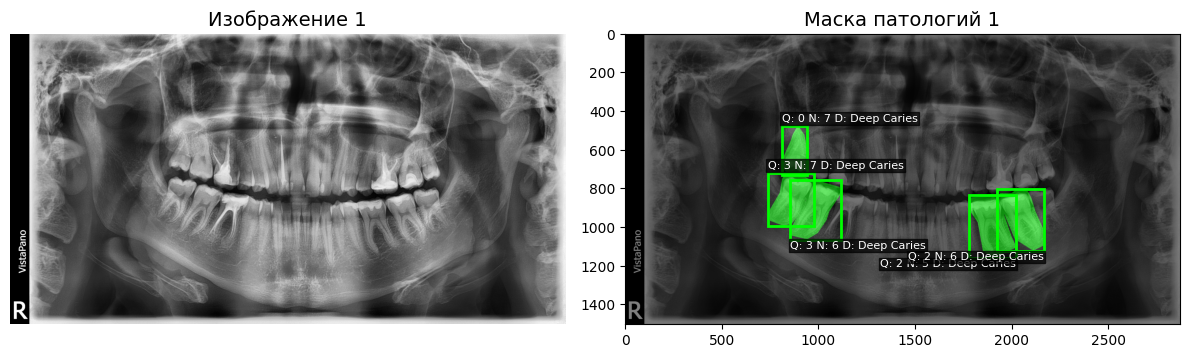

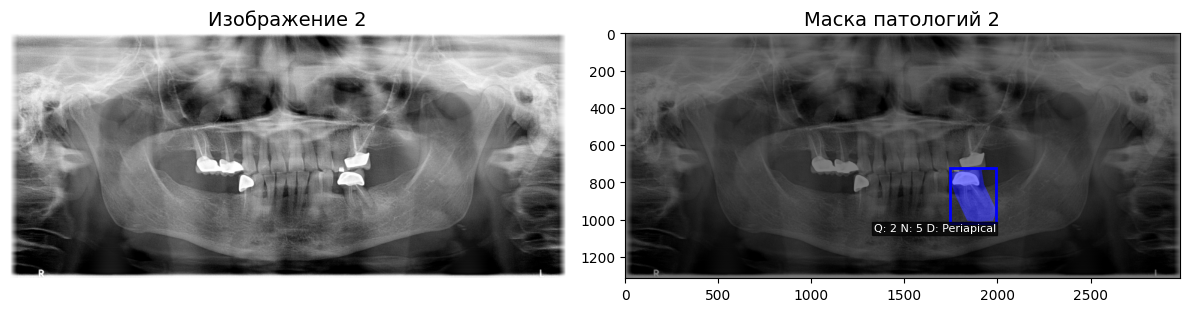

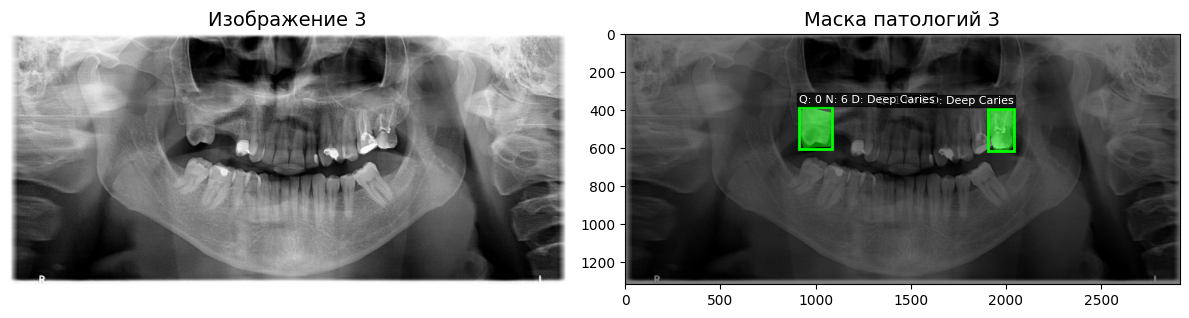

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 512, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512, 512, 64)   │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 128)  │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)       

 Total params: 31,054,405 (118.46 MB)

 Trainable params: 31,042,629 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Модель скомпилирована с модифицированной целевой функцией для точных предсказаний
Система настроена и готова к обучению
Подготовка данных для обучения...
Обучающая выборка: 542 изображений
Валидационная выборка: 136 изображений
Перекомпиляция модели с дополнительными метриками мониторинга...
Начало обучения модели на 542 изображениях...
Обучение будет выполняться максимум 50 эпох с ранней остановкой
Используется размер батча: 8
Используется модифицированная целевая функция с акцентом на точность предсказаний
Все компоненты целевой функции будут отслеживаться в процессе обучения
Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2731 - calibration_error_metric: 0.1864 - dice_coefficient: 0.0207 - loss: 3.0921 - mean_iou: 0.0120 - sensitivity_metric: 0.0904 - specificity_metric: 0.9712 - weighted_dice_metric: 0.0217
Epoch 1: val_weighted_dice_metric improved from -inf to 0.02132, saving model to /content/results/best_model_enhanced.keras

Компоненты целевой функции после эпох

In [ ]:
# 9. Вспомогательные функции с поддержкой модифицированной целевой функции для точных предсказаний

def train_model(dataset_path, num_epochs=None):
    """
    Запуск обучения модели.

    Аргументы:
        dataset_path (str): Путь к датасету
        num_epochs (int, optional): Количество эпох обучения

    Возвращает:
        StomatologyDiagnosisSystem: Обученная система
    """
    # Настройка количества эпох
    if num_epochs is not None:
        CONFIG["epochs"] = num_epochs

    # Инициализация системы
    system = StomatologyDiagnosisSystem(dataset_path)

    # Настройка и обучение
    system.setup()
    system.train()

    # Сохранение результатов
    system.save()

    return system

def train_model_with_enhanced_loss(dataset_path, num_epochs=None):
    """
    Запуск обучения модели с модифицированной целевой функцией для точных предсказаний.

    Аргументы:
        dataset_path (str): Путь к датасету
        num_epochs (int, optional): Количество эпох обучения

    Возвращает:
        EnhancedStomatologyDiagnosisSystem: Обученная система
    """
    # Настройка количества эпох
    if num_epochs is not None:
        CONFIG["epochs"] = num_epochs

    # Инициализация усовершенствованной системы
    system = EnhancedStomatologyDiagnosisSystem(dataset_path)

    # Настройка с использованием модифицированной целевой функции
    system.setup(use_enhanced_loss=True)

    # Обучение с расширенными метриками
    system.train()

    # Сохранение результатов
    system.save(os.path.join(RESULTS_DIR, f"enhanced_model_{time.strftime('%Y%m%d-%H%M%S')}"))

    return system

def compare_models(dataset_path, num_epochs=20):
    """
    Сравнение стандартной модели и модели с модифицированной целевой функцией.

    Аргументы:
        dataset_path (str): Путь к датасету
        num_epochs (int): Количество эпох обучения для сравнения

    Возвращает:
        tuple: (standard_system, enhanced_system) - обе обученные системы
    """
    # Настройка количества эпох
    CONFIG["epochs"] = num_epochs

    print("=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
    print("1. Обучение стандартной модели")

    # Инициализация стандартной системы
    standard_system = StomatologyDiagnosisSystem(dataset_path)
    standard_system.setup()
    standard_history = standard_system.train()

    print("\n2. Обучение модели с модифицированной целевой функцией")

    # Инициализация усовершенствованной системы
    enhanced_system = EnhancedStomatologyDiagnosisSystem(dataset_path)
    enhanced_system.setup(use_enhanced_loss=True)
    enhanced_history = enhanced_system.train()

    # Сравнение результатов
    if standard_history and enhanced_history:
        # Визуализация сравнения моделей
        _visualize_models_comparison(standard_history, enhanced_history)

        # Если есть данные, проверяем на тестовом изображении
        if standard_system.dataset and len(standard_system.dataset.images) > 0:
            test_img = np.random.choice(standard_system.dataset.images)
            print(f"\nТестирование на изображении: {test_img}")

            # Тестирование обеих моделей
            plt.figure(figsize=(20, 10))

            plt.subplot(1, 2, 1)
            plt.title("Стандартная модель", fontsize=16)
            standard_system.predict_and_visualize(test_img)

            plt.subplot(1, 2, 2)
            plt.title("Модель с модифицированной целевой функцией", fontsize=16)
            enhanced_system.predict_and_visualize(test_img)

            plt.tight_layout()
            plt.show()

    return standard_system, enhanced_system

def _visualize_models_comparison(standard_history, enhanced_history):
    """
    Визуализация сравнения результатов обучения стандартной и усовершенствованной моделей.

    Аргументы:
        standard_history: История обучения стандартной модели
        enhanced_history: История обучения модели с модифицированной целевой функцией
    """
    plt.figure(figsize=(20, 15))

    # 1. График функции потерь
    plt.subplot(2, 2, 1)
    plt.plot(standard_history.history['loss'], 'b-', label='Стандартная модель (обучение)')
    plt.plot(standard_history.history['val_loss'], 'b--', label='Стандартная модель (валидация)')
    plt.plot(enhanced_history.history['loss'], 'r-', label='Улучшенная модель (обучение)')
    plt.plot(enhanced_history.history['val_loss'], 'r--', label='Улучшенная модель (валидация)')
    plt.title('Сравнение функции потерь', fontsize=14)
    plt.xlabel('Эпоха')
    plt.ylabel('Значение потерь')
    plt.legend()
    plt.grid(True)

    # 2. График метрики Dice (F-мера)
    plt.subplot(2, 2, 2)
    # Проверяем наличие метрики в разных вариантах названий
    dice_metrics = ['dice_coefficient', 'weighted_dice_metric']

    for history, color, model_name in [(standard_history, 'b', 'Стандартная модель'),
                                        (enhanced_history, 'r', 'Улучшенная модель')]:
        for metric in dice_metrics:
            if metric in history.history:
                plt.plot(history.history[metric], f'{color}-', label=f'{model_name} (обучение)')
                plt.plot(history.history[f'val_{metric}'], f'{color}--', label=f'{model_name} (валидация)')
                break

    plt.title('Сравнение коэффициента Dice (F-мера)', fontsize=14)
    plt.xlabel('Эпоха')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)

    # 3. График метрики точности
    plt.subplot(2, 2, 3)
    plt.plot(standard_history.history['accuracy'], 'b-', label='Стандартная модель (обучение)')
    plt.plot(standard_history.history['val_accuracy'], 'b--', label='Стандартная модель (валидация)')
    plt.plot(enhanced_history.history['accuracy'], 'r-', label='Улучшенная модель (обучение)')
    plt.plot(enhanced_history.history['val_accuracy'], 'r--', label='Улучшенная модель (валидация)')
    plt.title('Сравнение точности', fontsize=14)
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.grid(True)

    # 4. Дополнительные метрики для улучшенной модели
    plt.subplot(2, 2, 4)

    # Проверяем наличие дополнительных метрик
    additional_metrics = ['sensitivity_metric', 'specificity_metric', 'calibration_error_metric']

    for metric in additional_metrics:
        if metric in enhanced_history.history:
            plt.plot(enhanced_history.history[metric], label=f'{metric} (обучение)')
            if f'val_{metric}' in enhanced_history.history:
                plt.plot(enhanced_history.history[f'val_{metric}'], '--', label=f'{metric} (валидация)')

    plt.title('Дополнительные метрики улучшенной модели', fontsize=14)
    plt.xlabel('Эпоха')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'models_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

def load_and_use_model(model_path, image_path=None):
    """
    Загрузка предобученной модели и использование для предсказания.

    Аргументы:
        model_path (str): Путь к предобученной модели
        image_path (str, optional): Путь к изображению для предсказания

    Возвращает:
        StomatologyDiagnosisSystem: Загруженная система
    """
    # Инициализация системы
    system = StomatologyDiagnosisSystem(None)

    # Инициализация датасета для загрузки определений классов
    system.dataset = DENTEXDataset(download_dentex_dataset())

    # Инициализация пустой модели с правильным числом классов
    system.model = UNetModel(num_classes=system.dataset.num_classes)

    # Загрузка модели
    system.load(model_path)

    # Если указан путь к изображению, выполняем предсказание
    if image_path:
        system.predict_and_visualize(image_path)

    return system

def load_and_use_enhanced_model(model_path, image_path=None):
    """
    Загрузка предобученной модели с модифицированной целевой функцией.

    Аргументы:
        model_path (str): Путь к предобученной модели
        image_path (str, optional): Путь к изображению для предсказания

    Возвращает:
        EnhancedStomatologyDiagnosisSystem: Загруженная система
    """
    # Инициализация усовершенствованной системы
    system = EnhancedStomatologyDiagnosisSystem(None)

    # Инициализация датасета для загрузки определений классов
    system.dataset = DENTEXDataset(download_dentex_dataset())

    # Создаем экземпляр класса с модифицированной целевой функцией
    dental_loss = DentalSegmentationLoss(num_classes=system.dataset.num_classes)

    # Инициализация пустой модели с правильным числом классов
    system.model = UNetModel(num_classes=system.dataset.num_classes)

    # Регистрируем пользовательские метрики для загрузки модели
    custom_objects = {
        'sensitivity_metric': sensitivity_metric,
        'specificity_metric': specificity_metric,
        'weighted_dice_metric': weighted_dice_metric,
        'calibration_error_metric': calibration_error_metric,
        'loss': dental_loss.create_loss_function()
    }

    # Загрузка модели с пользовательскими объектами
    print(f"Загрузка модели из {model_path}")
    system.model.model = keras.models.load_model(model_path, custom_objects=custom_objects)

    print("Модель успешно загружена")

    # Если указан путь к изображению, выполняем предсказание
    if image_path:
        system.predict_and_visualize(image_path)

    return system

def main():
    """
    Основная функция для запуска системы.
    Выбор между стандартной моделью и моделью с модифицированной целевой функцией.
    """
    # Определяем путь к датасету
    dataset_path = download_dentex_dataset()

    if not dataset_path or not os.path.exists(dataset_path):
        print("ОШИБКА: Датасет не найден. Проверьте путь к данным.")
        return

    # Режим работы: 'standard' - стандартная модель, 'enhanced' - модель с модифицированной целевой функцией,
    # 'compare' - сравнение моделей, 'predict' - предсказание
    mode = 'enhanced'  # Можно изменить

    if mode == 'standard':
        # Обучение стандартной модели
        system = train_model(dataset_path, num_epochs=50)

        # Тестирование на случайном изображении
        if system and system.history and len(system.dataset.images) > 0:
            test_img = np.random.choice(system.dataset.images)
            print(f"\nТестирование на изображении: {test_img}")
            system.predict_and_visualize(test_img)

    elif mode == 'enhanced':
        # Обучение модели с модифицированной целевой функцией
        system = train_model_with_enhanced_loss(dataset_path, num_epochs=50)

        # Тестирование на случайном изображении
        if system and system.history and len(system.dataset.images) > 0:
            test_img = np.random.choice(system.dataset.images)
            print(f"\nТестирование на изображении: {test_img}")
            system.predict_and_visualize(test_img)

    elif mode == 'compare':
        # Сравнение стандартной модели и модели с модифицированной целевой функцией
        standard_system, enhanced_system = compare_models(dataset_path, num_epochs=30)

    elif mode == 'predict':
        # Определяем, какую модель использовать
        enhanced_models = glob.glob(os.path.join(RESULTS_DIR, "enhanced_model_*.keras"))
        standard_models = glob.glob(os.path.join(RESULTS_DIR, "dentex_unet_model_*.keras"))

        model_path = None
        use_enhanced = True

        if enhanced_models:
            model_path = enhanced_models[0]
            print(f"Найдена модель с модифицированной целевой функцией: {model_path}")
        elif standard_models:
            model_path = standard_models[0]
            use_enhanced = False
            print(f"Найдена стандартная модель: {model_path}")
        else:
            print("Нет доступных моделей. Запустите обучение сначала.")
            return

        # Выбор изображения для предсказания
        image_path = None
        if os.path.exists(dataset_path):
            dataset = DENTEXDataset(dataset_path)
            if len(dataset.images) > 0:
                image_path = np.random.choice(dataset.images)
                print(f"Выбрано случайное изображение: {image_path}")
            else:
                print("ПРЕДУПРЕЖДЕНИЕ: Нет доступных изображений для тестирования.")

        if image_path:
            # Загрузка модели и предсказание
            if use_enhanced:
                system = load_and_use_enhanced_model(model_path, image_path)
            else:
                system = load_and_use_model(model_path, image_path)
        else:
            print("ОШИБКА: Нет изображений для тестирования.")

    else:
        print(f"Неизвестный режим работы: {mode}")

# Запуск основной функции
if __name__ == "__main__":
    main()

Ячейка 10

In [ ]:
# 10. Запуск тестирования системы

# Тестируем только загрузку датасета и визуализацию образцов
dataset_path = download_dentex_dataset()
dataset = DENTEXDataset(dataset_path)

# Визуализация образцов данных
print("Визуализация образцов данных из датасета:")
dataset.visualize_samples(3, visualization_style='smart_labels')

# Создаем экземпляр системы диагностики
print("\nСоздание системы диагностики с улучшенной целевой функцией...")
system = EnhancedStomatologyDiagnosisSystem(dataset_path)

# Настраиваем систему без запуска обучения
system.setup(use_enhanced_loss=True)

print("\nСистема настроена. Готова к обучению и тестированию.")
print("Для запуска обучения выполните: system.train()")
print("Для тестирования на конкретном изображении выполните: system.predict_and_visualize(image_path)")

# Выводим информацию о системе
print("\nИнформация о системе:")
print(f"- Количество классов патологий: {system.dataset.num_classes}")
print(f"- Количество загруженных изображений: {len(system.dataset.images)}")
print(f"- Размер изображений для модели: {CONFIG['img_size']}x{CONFIG['img_size']}")
print(f"- Целевая функция: Модифицированная для точных предсказаний")
print(f"- Веса для классов патологий: {CONFIG['class_weights']}")

Ячейка 11

In [ ]:
# 11. Валидация модели на отдельном наборе данных

def validate_model(model_path=None, dataset_path=None):
    """
    Валидация модели на отдельном наборе данных.

    Args:
        model_path (str): Путь к предобученной модели. Если None, ищет последнюю модель.
        dataset_path (str): Путь к датасету. Если None, использует стандартный путь.

    Returns:
        dict: Метрики валидации
    """
    # Определяем путь к датасету
    if dataset_path is None:
        dataset_path = download_dentex_dataset()

    # Ищем модель, если путь не указан
    if model_path is None:
        enhanced_models = glob.glob(os.path.join(RESULTS_DIR, "enhanced_model_*.keras"))
        standard_models = glob.glob(os.path.join(RESULTS_DIR, "dentex_unet_model_*.keras"))

        if enhanced_models:
            model_path = enhanced_models[0]
            use_enhanced = True
            print(f"Используем улучшенную модель: {model_path}")
        elif standard_models:
            model_path = standard_models[0]
            use_enhanced = False
            print(f"Используем стандартную модель: {model_path}")
        else:
            print("Модель не найдена. Сначала обучите модель.")
            return None
    else:
        # Определяем тип модели по имени файла
        use_enhanced = "enhanced" in os.path.basename(model_path).lower()

    # Создаем датасет и подготавливаем данные
    validation_dataset = DENTEXDataset(dataset_path)

    # Проверяем наличие папки validation_data для специального валидационного набора
    validation_path = os.path.join(dataset_path, "validation_data")
    if os.path.exists(validation_path):
        print(f"Найдена папка validation_data: {validation_path}")
        # Используем специальный валидационный датасет
        val_dataset = DENTEXDataset(validation_path)

        # Если датасет пустой, возвращаемся к основному
        if len(val_dataset.images) == 0:
            print("Валидационный датасет пуст. Используем основной датасет.")
            val_dataset = validation_dataset
    else:
        print("Папка validation_data не найдена. Используем подвыборку из основного датасета.")
        val_dataset = validation_dataset

    # Получаем валидационный генератор
    _, val_generator, _, val_count = val_dataset.prepare_dataset()

    # Если нет данных для валидации, завершаем выполнение
    if val_count == 0:
        print("Нет данных для валидации.")
        return None

    # Определяем количество шагов для валидации
    val_steps = val_count // CONFIG["batch_size"] + (1 if val_count % CONFIG["batch_size"] > 0 else 0)

    print(f"Валидация будет выполнена на {val_count} изображениях.")

    # Загружаем систему диагностики с нужной моделью
    if use_enhanced:
        system = load_and_use_enhanced_model(model_path)
    else:
        system = load_and_use_model(model_path)

    # Выполняем валидацию
    print("Выполняем валидацию модели...")
    metrics = system.model.model.evaluate(val_generator, steps=val_steps)

    # Преобразуем результаты в словарь
    metric_names = ['loss']
    metric_names.extend(system.model.model.metrics_names)

    # Убеждаемся, что длины списков совпадают
    if len(metric_names) > len(metrics):
        metric_names = metric_names[:len(metrics)]
    elif len(metric_names) < len(metrics):
        # Добавляем обобщенные имена для неизвестных метрик
        for i in range(len(metric_names), len(metrics)):
            metric_names.append(f'metric_{i}')

    validation_results = dict(zip(metric_names, metrics))

    # Выводим результаты
    print("\nРезультаты валидации:")
    for name, value in validation_results.items():
        print(f"{name}: {value:.4f}")

    # Визуализируем результаты на случайных изображениях
    visualize_validation_examples(system, val_dataset)

    # Если это улучшенная модель с акцентом на точность предсказаний,
    # дополнительно оцениваем калибровку
    if use_enhanced and isinstance(system, EnhancedStomatologyDiagnosisSystem):
        print("\nОценка калибровки вероятностей модели...")
        system.evaluate_calibration(val_generator, num_steps=min(10, val_steps))

    return validation_results

def visualize_validation_examples(system, val_dataset, num_examples=3):
    """
    Визуализация работы модели на случайных примерах из валидационного набора.

    Args:
        system: Система диагностики с загруженной моделью
        val_dataset: Валидационный датасет
        num_examples: Количество примеров для визуализации
    """
    # Проверяем наличие изображений
    if len(val_dataset.images) == 0:
        print("Нет изображений для визуализации.")
        return

    # Выбираем случайные изображения
    random_images = np.random.choice(val_dataset.images,
                                   min(num_examples, len(val_dataset.images)),
                                   replace=False)

    print(f"\nВизуализация результатов на {len(random_images)} случайных изображениях:")

    for i, img_path in enumerate(random_images):
        print(f"\nПример {i+1}: {os.path.basename(img_path)}")
        # Предсказание и визуализация
        system.predict_and_visualize(img_path)

    # Создаем сводную визуализацию с метриками качества по классам
    print("\nСводные метрики по классам патологий:")
    evaluate_class_metrics(system, val_dataset)

def evaluate_class_metrics(system, val_dataset, num_samples=50):
    """
    Оценка метрик качества по отдельным классам патологий.

    Args:
        system: Система диагностики с загруженной моделью
        val_dataset: Валидационный датасет
        num_samples: Максимальное количество образцов для оценки
    """
    # Проверяем наличие изображений и аннотаций
    if len(val_dataset.images) == 0 or len(val_dataset.annotations) == 0:
        print("Нет размеченных данных для оценки метрик по классам.")
        return

    # Ограничиваем количество образцов
    num_samples = min(num_samples, len(val_dataset.images))

    # Выбираем случайные индексы
    indices = np.random.choice(len(val_dataset.images), num_samples, replace=False)

    # Инициализируем счетчики для каждого класса
    class_metrics = {}
    for class_id in range(1, system.dataset.num_classes):  # Пропускаем фон (класс 0)
        class_metrics[class_id] = {
            'tp': 0,  # True Positives
            'fp': 0,  # False Positives
            'fn': 0,  # False Negatives
            'tn': 0,  # True Negatives
        }

    # Обрабатываем образцы
    for idx in indices:
        img_path = val_dataset.images[idx]
        annotations = val_dataset.annotations[idx]

        # Загружаем изображение
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        height, width = img.shape

        # Создаем маски истинных патологий
        true_mask, _ = val_dataset.create_multiclass_masks(annotations, width, height)

        # Подготавливаем изображение для предсказания
        img_resized = cv2.resize(img, (CONFIG["img_size"], CONFIG["img_size"]))
        img_normalized = img_resized / 255.0
        img_input = np.expand_dims(img_normalized, axis=-1)
        img_input = np.expand_dims(img_input, axis=0)

        # Получаем предсказание
        prediction_probs = system.model.model.predict(img_input)[0]
        prediction_mask = np.argmax(prediction_probs, axis=-1)

        # Меняем размер предсказания до оригинального размера
        pred_mask = cv2.resize(prediction_mask.astype(np.uint8),
                             (width, height),
                             interpolation=cv2.INTER_NEAREST)

        # Для каждого класса обновляем метрики
        for class_id in range(1, system.dataset.num_classes):
            true_positive = np.logical_and(true_mask == class_id, pred_mask == class_id).sum()
            false_positive = np.logical_and(true_mask != class_id, pred_mask == class_id).sum()
            false_negative = np.logical_and(true_mask == class_id, pred_mask != class_id).sum()
            true_negative = np.logical_and(true_mask != class_id, pred_mask != class_id).sum()

            class_metrics[class_id]['tp'] += true_positive
            class_metrics[class_id]['fp'] += false_positive
            class_metrics[class_id]['fn'] += false_negative
            class_metrics[class_id]['tn'] += true_negative

    # Вычисляем метрики для каждого класса
    results = {}
    for class_id, metrics in class_metrics.items():
        tp = metrics['tp']
        fp = metrics['fp']
        fn = metrics['fn']
        tn = metrics['tn']

        # Избегаем деления на ноль
        epsilon = 1e-7

        # Вычисляем метрики
        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)  # также известна как чувствительность
        specificity = tn / (tn + fp + epsilon)
        f1_score = 2 * precision * recall / (precision + recall + epsilon)
        accuracy = (tp + tn) / (tp + fp + fn + tn + epsilon)

        results[class_id] = {
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1_score': f1_score,
            'accuracy': accuracy,
            'support': tp + fn  # общее количество положительных примеров
        }

    # Визуализируем результаты
    plt.figure(figsize=(14, 10))

    metrics_to_plot = ['precision', 'recall', 'specificity', 'f1_score', 'accuracy']
    classes = list(results.keys())
    class_names = [system.disease_classes.get(class_id, f"Класс {class_id}") for class_id in classes]

    # Создаем таблицу метрик
    cell_text = []
    for class_id in classes:
        row = [f"{results[class_id][metric]:.3f}" for metric in metrics_to_plot]
        row.append(str(results[class_id]['support']))
        cell_text.append(row)

    # Добавляем заголовки метрик
    metric_headers = ['Точность', 'Полнота', 'Специфичность', 'F1-мера', 'Точность', 'Количество']

    # Рисуем таблицу
    plt.subplot(2, 1, 1)
    plt.axis('off')
    plt.table(cellText=cell_text,
           rowLabels=class_names,
           colLabels=metric_headers,
           loc='center',
           cellLoc='center')
    plt.title('Метрики качества по классам патологий', fontsize=16)

    # Рисуем график
    plt.subplot(2, 1, 2)

    x = np.arange(len(class_names))
    width = 0.15
    multiplier = 0

    for metric in metrics_to_plot:
        offset = width * multiplier
        plt.bar(x + offset, [results[class_id][metric] for class_id in classes],
              width, label=metric_headers[metrics_to_plot.index(metric)])
        multiplier += 1

    plt.xlabel('Класс патологии')
    plt.ylabel('Значение метрики')
    plt.title('Сравнение метрик по классам')
    plt.xticks(x + width * 2, class_names)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
             fancybox=True, shadow=True, ncol=5)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'validation_class_metrics.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Выводим детальные результаты
    print("\nДетальные результаты по классам:")
    for class_id in classes:
        class_name = system.disease_classes.get(class_id, f"Класс {class_id}")
        print(f"\n{class_name}:")
        print(f"  Точность (Precision): {results[class_id]['precision']:.4f}")
        print(f"  Полнота (Recall):     {results[class_id]['recall']:.4f}")
        print(f"  Специфичность:        {results[class_id]['specificity']:.4f}")
        print(f"  F1-мера:              {results[class_id]['f1_score']:.4f}")
        print(f"  Точность (Accuracy):  {results[class_id]['accuracy']:.4f}")
        print(f"  Количество примеров:  {results[class_id]['support']}")

    return results

# Запуск валидации модели
print("Запуск валидации модели на отдельном наборе данных...")
validation_results = validate_model()

if validation_results:
    print("\nВалидация завершена успешно.")